# Yelp Open Dataset - Drivers of High Ratings & Geographic Hotspots

### **Goal:** Use the Yelp business data to learn *what makes experiences highly rated* and *where top-rated experiences cluster*.

**What this notebook shows:**
1. Data loading & cleaning.
2. Analysis answering two questions:
   - **Q1 (Performance drivers):** Which business attributes are linked to high ratings?
   - **Q2 (Geographic insights):** Which cities/neighborhoods have the most highly rated businesses?
3. Actionable takeaways

## Table of Contents
1. Setup & Project Structure  
2. Quick Data Preview (business.json)  
3. Data Cleaning & Normalization (attributes, categories, hours)  
4. EDA (distributions, top categories, review counts)  
5. Q1 - Performance Drivers (what predicts high ratings?)  
6. Q2 - Geographic Insights (where are the hotspots?)  
7. Recommendations for Warmer  
8. Challenges & Next Steps

## 1. Setup & Project Structure

In [1]:
# PATH DISCOVERY (customized to your folder)

from pathlib import Path

PROJECT_ROOT = Path.cwd()
DATA_DIR     = PROJECT_ROOT / "data"       
OUTPUTS_DIR  = PROJECT_ROOT / "outputs"

CANDIDATE_DIRS = [
    PROJECT_ROOT,  # current folder
    PROJECT_ROOT / "Yelp-JSON" / "Yelp JSON" / "yelp_dataset",
    PROJECT_ROOT / "Yelp JSON" / "yelp_dataset",
    PROJECT_ROOT / "yelp_dataset",
    DATA_DIR,  
]

# Expected Yelp JSON filenames (as shipped by Yelp)
FILENAMES = {
    "business": "yelp_academic_dataset_business.json",
    "review":   "yelp_academic_dataset_review.json",
    "user":     "yelp_academic_dataset_user.json",
    "checkin":  "yelp_academic_dataset_checkin.json",
    "tip":      "yelp_academic_dataset_tip.json",
}

def find_file(fname: str):
    """Return the first path that exists for fname by scanning CANDIDATE_DIRS (and their subfolders)."""
    for base in CANDIDATE_DIRS:
        direct = base / fname
        if direct.exists():
            return direct.resolve()
    # if not found directly, search recursively under each candidate
    for base in CANDIDATE_DIRS:
        if base.exists():
            hits = list(base.rglob(fname))
            if hits:
                return hits[0].resolve()
    return None

# Find all key files
BUSINESS_JSON_PATH = find_file(FILENAMES["business"])
REVIEW_JSON_PATH   = find_file(FILENAMES["review"])  # removing from project path to help memory
USER_JSON_PATH     = find_file(FILENAMES["user"]) # removing from project path to help memory
CHECKIN_JSON_PATH  = find_file(FILENAMES["checkin"]) # removing from project path to help memory
TIP_JSON_PATH      = find_file(FILENAMES["tip"]) # removing from project path to help memory

# Report
def _pretty_size(p: Path | None) -> str:
    """Return a human-readable size in MB, or '-' if not available."""
    try:
        return f"{p.stat().st_size / (1024 * 1024):,.1f} MB"
    except Exception:
        return "-"

# Returning path
def _fmt_path_redacted(p: Path | None, keep_tail_parts: int = 2) -> str:
    """
    Return a redacted path string:
    - Prefer showing path relative to PROJECT_ROOT if possible.
    - Only show the last `keep_tail_parts` segments, prefixed with '…/'.
    - If p is None, return '(not found)'.
    """
    if p is None:
        return "(not found)"
    try:
        rel = p.relative_to(PROJECT_ROOT)
        parts = rel.as_posix().split("/")
    except Exception:
        parts = p.as_posix().split("/")
    tail = "/".join(parts[-keep_tail_parts:]) if parts else p.name
    return f"…/{tail}"


print("Yelp dataset file discovery:")
for label, p in [
    ("business", BUSINESS_JSON_PATH),
    ("review",   REVIEW_JSON_PATH),
    ("user",     USER_JSON_PATH),
    ("checkin",  CHECKIN_JSON_PATH),
    ("tip",      TIP_JSON_PATH),
]:
    status = "Present" if p and p.exists() else "Missing"
    print(f"  {status:9s} {label:8s} → {_fmt_path_redacted(p)}  ({_pretty_size(p)})")




Yelp dataset file discovery:
  Present   business → …/yelp_dataset/yelp_academic_dataset_business.json  (113.4 MB)
  Missing   review   → (not found)  (-)
  Missing   user     → (not found)  (-)
  Missing   checkin  → (not found)  (-)
  Missing   tip      → (not found)  (-)


### Imports and display options

In [17]:
import json
import gc
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import __version__ as sklver
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

In [16]:
# Display options
pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 200)

print("pandas:", pd.__version__)
print("numpy :", np.__version__)

pandas: 2.2.3
numpy : 1.26.4


In [57]:

import matplotlib as mpl

# Brand palette (approximated from the screenshot)
WARMER_DARK   = "#0F2F2E"  # primary pine/teal
WARMER_WHITE  = "#FFFFFF"
SUN_YELLOW    = "#FFD66B"
SUN_ORANGE    = "#FF8A3D"
SUN_CORAL     = "#FF5E5B"
SUN_MAGENTA   = "#D64292"

INK_DARK      = "#111827"  # near-black for text on light
GRID_LIGHT    = "#E5E7EB"  # subtle grid/border
BG            = "#FFFFFF"  # white slide background

# Font family (edit to "Inter" or "Work Sans" if installed)
FONT = "DejaVu Sans"

mpl.rcParams.update({
    # Figure & axes
    "figure.figsize": (6, 4),       # slide-friendly aspect (1280x900 scaled)
    "figure.dpi": 150,
    "figure.facecolor": BG,
    "axes.facecolor": BG,
    "axes.edgecolor": GRID_LIGHT,
    "axes.linewidth": 1.0,
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.titlecolor": INK_DARK,
    "axes.labelsize": 13,
    "axes.labelcolor": INK_DARK,
    "axes.grid": True,
    "grid.color": GRID_LIGHT,
    "grid.linewidth": 0.8,
    "grid.alpha": 1.0,
    "axes.axisbelow": True,

    # Font
    "font.family": "sans-serif",
    "font.sans-serif": [FONT, "Arial", "Helvetica", "DejaVu Sans"],

    # Ticks
    "xtick.color": INK_DARK,
    "ytick.color": INK_DARK,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,

    # Legend
    "legend.frameon": False,
    "legend.fontsize": 11,

    # Lines & color cycle (primary + warm accents)
    "lines.linewidth": 2.2,
    "axes.prop_cycle": mpl.cycler(color=[WARMER_DARK, SUN_ORANGE, SUN_MAGENTA, SUN_CORAL, SUN_YELLOW]),
})

# Helper: default save settings (tight, hi-res)
SAVE_KW = dict(dpi=150, bbox_inches="tight", facecolor=BG)


## 2. Quick data preview: `business.json`

In [3]:
chunk_iter = pd.read_json(
    BUSINESS_JSON_PATH,
    lines=True,
    chunksize=50000,
)

first_chunk = next(chunk_iter)
print("Chunk shape:", first_chunk.shape)
print("\nColumns:", list(first_chunk.columns))

first_chunk.head(5)


Chunk shape: (50000, 14)

Columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', 'Wednesday': '8:0-18:30', 'Thursday': '8:0-18:30', 'Friday': '8:0-18:30', 'Saturday': '8:0-14:0'}"
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsPriceRange2': '2', 'CoatCheck': 'False', 'RestaurantsTakeOut': 'False', 'RestaurantsDelivery': 'False', 'Caters': 'False',...","Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', 'Wednesday': '8:0-22:0', 'Thursday': '8:0-22:0', 'Friday': '8:0-23:0', 'Saturday': '8:0-23:0', 'Sunday': '8:0-22:0'}"
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': ...","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', 'Wednesday': '7:0-20:0', 'Thursday': '7:0-20:0', 'Friday': '7:0-21:0', 'Saturday': '7:0-21:0', 'Sunday': '7:0-21:0'}"
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'WheelchairAccessible': 'True', 'RestaurantsTakeOut': 'True', 'BusinessParking': '{'garage': None, 'street': None, 'validated': None, 'lot': True, 'valet': F...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-22:0', 'Friday': '12:0-22:0', 'Saturday': '12:0-22:0', 'Sunday': '12:0-18:0'}"


## 3. Data Cleaning & Normalization

### Column overview and null scan (sample chunk)

In [ ]:

# Dtype summary
dtype_summary = first_chunk.dtypes.astype(str).to_frame("dtype")
print("Dtype summary:")
display(dtype_summary)

# Null percentage summary
null_pct = (first_chunk.isna().mean().sort_values(ascending=False) * 100).round(2).to_frame("null_pct")
print("Null percentage by column (sample chunk):")
display(null_pct)

# Inspect categories and hours presence
print("Non-null counts (sample chunk):")
print(first_chunk[["categories", "attributes", "hours"]].notna().sum())

# Attribute key frequency (top 25)
attr_keys = Counter()
for d in first_chunk["attributes"].dropna():
    if isinstance(d, dict):
        attr_keys.update(d.keys())

attr_keys_df = (
    pd.DataFrame(attr_keys.most_common(25), columns=["attribute_key", "count"])
    if attr_keys
    else pd.DataFrame(columns=["attribute_key", "count"])
)

print("Top attribute keys (sample chunk):")
display(attr_keys_df)

# Example nested keys within BusinessParking, if present
bp_keys = Counter()
for d in first_chunk["attributes"].dropna():
    if isinstance(d, dict) and "BusinessParking" in d and isinstance(d["BusinessParking"], dict):
        bp_keys.update(d["BusinessParking"].keys())

if bp_keys:
    print("Nested keys under 'BusinessParking' (sample chunk):")
    display(pd.DataFrame(bp_keys.most_common(), columns=["parking_key", "count"]))
else:
    print("No nested 'BusinessParking' keys detected in the sample chunk.")


Dtype summary:


,dtype
business_id,object
name,object
address,object
city,object
state,object
postal_code,object
latitude,float64
longitude,float64
stars,float64
review_count,int64


Null percentage by column (sample chunk):


,null_pct
hours,15.47
attributes,8.92
categories,0.07
business_id,0.00
name,0.00
address,0.00
city,0.00
state,0.00
postal_code,0.00
latitude,0.00


Non-null counts (sample chunk):
categories    49963
attributes    45539
hours         42266
dtype: int64
Top attribute keys (sample chunk):


,attribute_key,count
0,BusinessAcceptsCreditCards,39828
1,BusinessParking,30280
2,RestaurantsPriceRange2,28260
3,BikeParking,24182
4,RestaurantsTakeOut,19892
5,WiFi,18996
6,RestaurantsDelivery,18721
7,GoodForKids,17886
8,OutdoorSeating,16167
9,RestaurantsReservations,15062


No nested 'BusinessParking' keys detected in the sample chunk.


### Cleaning helpers

In [5]:
import re
from datetime import datetime, timedelta

#  Generic coercion helpers

TRUE_SET  = {True, "true", "True", "TRUE", "yes", "Yes", "Y", "y", "1"}
FALSE_SET = {False, "false", "False", "FALSE", "no", "No", "N", "n", "0"}

def coerce_bool(x):
    """Return True/False/None from common truthy/falsey representations."""
    if x is None or x == "" or str(x).lower() in {"none", "null", "na", "n/a"}:
        return None
    if x in TRUE_SET:
        return True
    if x in FALSE_SET:
        return False
    return None

def coerce_float(x):
    """Return float or None."""
    try:
        return float(x)
    except Exception:
        return None

def coerce_str_clean(x):
    """Return stripped lowercase string or None."""
    if x is None:
        return None
    s = str(x).strip()
    return s.lower() if s else None

# Domain-specific mappings 

NOISE_LEVEL_MAP = {
    "quiet": 1,
    "average": 2,
    "loud": 3,
    "very_loud": 4,
    "very loud": 4,
}

ALCOHOL_MAP = {
    "none": "none",
    "beer_and_wine": "beer_wine",
    "beer and wine": "beer_wine",
    "full_bar": "full_bar",
    "full bar": "full_bar",
}

WIFI_MAP = {
    "no": "no",
    "free": "free",
    "paid": "paid",
}

#  Attributes flattening 

ATTR_KEYS_PRIMARY = [
    "BusinessAcceptsCreditCards",
    "BusinessParking",            # may be nested
    "RestaurantsPriceRange2",
    "BikeParking",
    "RestaurantsTakeOut",
    "WiFi",
    "RestaurantsDelivery",
    "GoodForKids",
    "OutdoorSeating",
    "RestaurantsReservations",
    "HasTV",
    "Ambience",                   # may be nested
    "RestaurantsGoodForGroups",
    "Alcohol",
    "ByAppointmentOnly",
    "Caters",
    "RestaurantsAttire",
    "NoiseLevel",
    "GoodForMeal",               # may be nested
    "WheelchairAccessible",
    "RestaurantsTableService",
    "DogsAllowed",
    "BusinessAcceptsBitcoin",
    "HappyHour",
    "DriveThru",
]

PARKING_SUBKEYS = ["garage", "street", "validated", "lot", "valet"]
AMBIENCE_SUBKEYS = [
    "romantic","intimate","classy","hipster","divey",
    "touristy","trendy","upscale","casual"
]
GOOD_FOR_MEAL_SUBKEYS = ["breakfast","brunch","lunch","dinner","dessert","latenight"]

def flatten_attributes(attr_obj):
    """
    Flatten selected attributes into a simple dict with scalar values.
    Handles nested dicts for parking, ambience, and good_for_meal.
    """
    out = {
        "accepts_credit_cards": None,
        "price": None,
        "bike_parking": None,
        "takeout": None,
        "wifi": None,
        "delivery": None,
        "good_for_kids": None,
        "outdoor_seating": None,
        "reservations": None,
        "has_tv": None,
        "good_for_groups": None,
        "alcohol": None,
        "by_appointment_only": None,
        "caters": None,
        "attire": None,
        "noise_level": None,
        "wheelchair_accessible": None,
        "table_service": None,
        "dogs_allowed": None,
        "bitcoin": None,
        "happy_hour": None,
        "drive_thru": None,
        # parking summary and common subkeys
        "parking_any": None,
        **{f"parking_{k}": None for k in PARKING_SUBKEYS},
        # ambience subkeys
        **{f"ambience_{k}": None for k in AMBIENCE_SUBKEYS},
        # meal suitability
        **{f"meal_{k}": None for k in GOOD_FOR_MEAL_SUBKEYS},
    }

    if not isinstance(attr_obj, dict):
        return out

    # Direct scalar attributes
    out["accepts_credit_cards"] = coerce_bool(attr_obj.get("BusinessAcceptsCreditCards"))
    out["price"]                = coerce_float(attr_obj.get("RestaurantsPriceRange2"))
    out["bike_parking"]         = coerce_bool(attr_obj.get("BikeParking"))
    out["takeout"]              = coerce_bool(attr_obj.get("RestaurantsTakeOut"))
    out["delivery"]             = coerce_bool(attr_obj.get("RestaurantsDelivery"))
    out["good_for_kids"]        = coerce_bool(attr_obj.get("GoodForKids"))
    out["outdoor_seating"]      = coerce_bool(attr_obj.get("OutdoorSeating"))
    out["reservations"]         = coerce_bool(attr_obj.get("RestaurantsReservations"))
    out["has_tv"]               = coerce_bool(attr_obj.get("HasTV"))
    out["good_for_groups"]      = coerce_bool(attr_obj.get("RestaurantsGoodForGroups"))
    out["by_appointment_only"]  = coerce_bool(attr_obj.get("ByAppointmentOnly"))
    out["caters"]               = coerce_bool(attr_obj.get("Caters"))
    out["wheelchair_accessible"]= coerce_bool(attr_obj.get("WheelchairAccessible"))
    out["table_service"]        = coerce_bool(attr_obj.get("RestaurantsTableService"))
    out["dogs_allowed"]         = coerce_bool(attr_obj.get("DogsAllowed"))
    out["bitcoin"]              = coerce_bool(attr_obj.get("BusinessAcceptsBitcoin"))
    out["happy_hour"]           = coerce_bool(attr_obj.get("HappyHour"))
    out["drive_thru"]           = coerce_bool(attr_obj.get("DriveThru"))

    # Categorical mappings
    wifi_raw = coerce_str_clean(attr_obj.get("WiFi"))
    out["wifi"] = WIFI_MAP.get(wifi_raw, None)

    alcohol_raw = coerce_str_clean(attr_obj.get("Alcohol"))
    out["alcohol"] = ALCOHOL_MAP.get(alcohol_raw, None)

    attire_raw = coerce_str_clean(attr_obj.get("RestaurantsAttire"))
    out["attire"] = attire_raw  # keep as string category

    noise_raw = coerce_str_clean(attr_obj.get("NoiseLevel"))
    out["noise_level"] = NOISE_LEVEL_MAP.get(noise_raw, None)

    # Nested: BusinessParking
    parking = attr_obj.get("BusinessParking")
    if isinstance(parking, dict):
        any_true = False
        for k in PARKING_SUBKEYS:
            val = coerce_bool(parking.get(k))
            out[f"parking_{k}"] = val
            any_true = any_true or (val is True)
        out["parking_any"] = True if any_true else (False if any_true is False else None)

    # Nested: Ambience
    amb = attr_obj.get("Ambience")
    if isinstance(amb, dict):
        for k in AMBIENCE_SUBKEYS:
            out[f"ambience_{k}"] = coerce_bool(amb.get(k))

    # Nested: GoodForMeal
    gfm = attr_obj.get("GoodForMeal")
    if isinstance(gfm, dict):
        for k in GOOD_FOR_MEAL_SUBKEYS:
            out[f"meal_{k}"] = coerce_bool(gfm.get(k))

    return out

# Categories parsing

def parse_categories(cat_field):
    """
    Return a list of cleaned category tokens or an empty list.
    Yelp provides categories as a comma-separated string.
    """
    if cat_field is None or pd.isna(cat_field):
        return []
    if isinstance(cat_field, list):
        raw = cat_field
    else:
        raw = str(cat_field).split(",")
    return [c.strip() for c in raw if c and c.strip()]

def primary_category(categories_list):
    """Return the first category if present."""
    return categories_list[0] if categories_list else None

# Hours parsing

HOUR_RE = re.compile(r"^(\d{1,2}):(\d{2})-(\d{1,2}):(\d{2})$")

def _parse_span_to_hours(span: str) -> float | None:
    """
    Convert 'HH:MM-HH:MM' to a duration in hours.
    Handles overnight spans by rolling close past midnight.
    """
    if not isinstance(span, str):
        return None
    m = HOUR_RE.match(span.strip())
    if not m:
        return None
    h1, m1, h2, m2 = map(int, m.groups())
    t1 = h1 * 60 + m1
    t2 = h2 * 60 + m2
    if t2 < t1:  # crosses midnight
        t2 += 24 * 60
    return (t2 - t1) / 60.0

DAYS = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

def weekly_hours_total(hours_obj) -> float | None:
    """
    Sum daily spans into total weekly open hours. Returns None if no valid spans.
    """
    if not isinstance(hours_obj, dict):
        return None
    total = 0.0
    seen = False
    for d in DAYS:
        span = hours_obj.get(d)
        dur = _parse_span_to_hours(span) if span else None
        if dur is not None:
            total += float(dur)
            seen = True
    return round(total, 2) if seen else None


### Apply cleaning to the sample chunk
**Purpose**: transform attributes, categories, and hours into analysis-ready columns, then review the result before processing the full file.

In [6]:
def process_business_chunk(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform a raw business chunk into an analysis-ready DataFrame.
    - Flattens attributes (including nested fields).
    - Parses categories into list, primary category, and count.
    - Derives weekly open hours.
    - Produces a compact set of columns for modeling and aggregation.
    """
    cols_keep = [
        "business_id", "name", "city", "state",
        "latitude", "longitude", "stars", "review_count", "is_open",
        "attributes", "categories", "hours",
    ]
    df = df.loc[:, [c for c in cols_keep if c in df.columns]].copy()

    # Attributes
    attr_df = df["attributes"].apply(flatten_attributes).apply(pd.Series)

    # Categories
    cats_list = df["categories"].apply(parse_categories)
    df["primary_category"] = cats_list.apply(primary_category)
    df["num_categories"]   = cats_list.apply(len)

    # Hours
    df["weekly_hours"] = df["hours"].apply(weekly_hours_total)

    # Label for downstream modeling
    df["high_rating"] = (df["stars"] >= 4.5).astype("int8")

    # Assemble output
    out = pd.concat(
        [
            df.drop(columns=["attributes", "categories", "hours"], errors="ignore"),
            attr_df,
        ],
        axis=1,
    )

    # Dtype adjustments for compactness
    int8_cols = ["is_open", "high_rating"]
    for c in int8_cols:
        if c in out.columns:
            out[c] = out[c].astype("int8")

    return out

# Apply to the preview chunk
cleaned_sample = process_business_chunk(first_chunk)

print("Cleaned sample shape:", cleaned_sample.shape)
display(cleaned_sample.head(10))

# Quick quality checks
summary_cols = [
    "stars", "review_count", "weekly_hours", "price",
    "primary_category", "accepts_credit_cards", "wifi", "alcohol",
]
present_cols = [c for c in summary_cols if c in cleaned_sample.columns]
print("\nSelected columns non-null counts (sample):")
display(cleaned_sample[present_cols].notna().sum().to_frame("non_null"))

print("Primary category (top 15):")
display(cleaned_sample["primary_category"].value_counts(dropna=True).head(15).to_frame("count"))

print("Stars distribution (sample):")
display(cleaned_sample["stars"].describe(percentiles=[0.25, 0.5, 0.75]))


Cleaned sample shape: (50000, 56)


,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,primary_category,num_categories,weekly_hours,high_rating,accepts_credit_cards,price,bike_parking,takeout,wifi,delivery,good_for_kids,outdoor_seating,reservations,has_tv,good_for_groups,alcohol,by_appointment_only,caters,attire,noise_level,wheelchair_accessible,table_service,dogs_allowed,bitcoin,happy_hour,drive_thru,parking_any,parking_garage,parking_street,parking_validated,parking_lot,parking_valet,ambience_romantic,ambience_intimate,ambience_classy,ambience_hipster,ambience_divey,ambience_touristy,ambience_trendy,ambience_upscale,ambience_casual,meal_breakfast,meal_brunch,meal_lunch,meal_dinner,meal_dessert,meal_latenight
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,34.426679,-119.711197,5.0,7,0,Doctors,6,NaN,1,None,NaN,None,None,NaN,None,None,None,None,None,None,None,True,None,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,1,Shipping Centers,5,NaN,0,True,NaN,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,32.223236,-110.880452,3.5,22,0,Department Stores,6,NaN,0,True,2.0,True,False,NaN,False,None,False,False,False,None,None,False,False,None,NaN,True,None,False,None,False,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,1,Restaurants,5,NaN,0,False,1.0,True,True,NaN,False,None,False,None,None,None,None,False,True,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,40.338183,-75.471659,4.5,13,1,Brewpubs,3,NaN,1,True,NaN,True,True,NaN,None,True,None,None,None,None,None,None,False,None,NaN,True,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,TN,36.269593,-87.058943,2.0,6,1,Burgers,6,NaN,0,True,1.0,False,True,NaN,True,True,True,False,True,True,None,False,False,u'casual',NaN,True,False,False,None,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,Brentwood,MO,38.627695,-90.340465,2.5,13,1,Sporting Goods,6,NaN,0,True,2.0,True,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,St. Petersburg,FL,27.766590,-82.732983,3.5,5,1,Synagogues,2,NaN,0,None,NaN,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,Affton,MO,38.565165,-90.321087,3.0,19,0,Pubs,7,NaN,0,True,1.0,None,True,NaN,False,True,True,False,True,True,None,None,True,u'casual',NaN,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,Nashville,TN,36.208102,-86.768170,1.5,10,1,Ice Cream & Frozen Yogurt,5,NaN,0,True,1.0,None,True,NaN,True,True,True,False,True,False,None,False,False,'casual',NaN,True,False,False,None,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Selected columns non-null counts (sample):


,non_null
stars,50000
review_count,50000
weekly_hours,2565
price,28242
primary_category,49963
accepts_credit_cards,39804
wifi,0
alcohol,16


Primary category (top 15):


,count
primary_category,
Restaurants,5013
Food,2268
Shopping,1796
Beauty & Spas,1434
Home Services,1276
Automotive,1147
Health & Medical,1028
Local Services,880
Nightlife,741


Stars distribution (sample):


count    50000.000000
mean         3.599200
std          0.974653
min          1.000000
25%          3.000000
50%          3.500000
75%          4.500000
max          5.000000
Name: stars, dtype: float64

### Patch attribute string normalization

In [7]:
import re

def coerce_str_clean(x):
    """Normalize attribute strings: strip quotes and unify spacing/case."""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    s = str(x).strip()

    # Strip leading u'..' or surrounding quotes
    if s.startswith("u'") and s.endswith("'"):
        s = s[2:-1]
    elif (s.startswith("'") and s.endswith("'")) or (s.startswith('"') and s.endswith('"')):
        s = s[1:-1]

    s = s.strip().lower()
    s = s.replace("/", " / ").replace("&", " and ").replace("-", " ")
    s = re.sub(r"\s+", " ", s)
    return s if s else None

# Re-define flatten_attributes to use the updated string cleaner
def flatten_attributes(attr_obj):
    out = {
        "accepts_credit_cards": None,
        "price": None,
        "bike_parking": None,
        "takeout": None,
        "wifi": None,
        "delivery": None,
        "good_for_kids": None,
        "outdoor_seating": None,
        "reservations": None,
        "has_tv": None,
        "good_for_groups": None,
        "alcohol": None,
        "by_appointment_only": None,
        "caters": None,
        "attire": None,
        "noise_level": None,
        "wheelchair_accessible": None,
        "table_service": None,
        "dogs_allowed": None,
        "bitcoin": None,
        "happy_hour": None,
        "drive_thru": None,
        "parking_any": None,
        **{f"parking_{k}": None for k in PARKING_SUBKEYS},
        **{f"ambience_{k}": None for k in AMBIENCE_SUBKEYS},
        **{f"meal_{k}": None for k in GOOD_FOR_MEAL_SUBKEYS},
    }

    if not isinstance(attr_obj, dict):
        return out

    out["accepts_credit_cards"] = coerce_bool(attr_obj.get("BusinessAcceptsCreditCards"))
    out["price"]                = coerce_float(attr_obj.get("RestaurantsPriceRange2"))
    out["bike_parking"]         = coerce_bool(attr_obj.get("BikeParking"))
    out["takeout"]              = coerce_bool(attr_obj.get("RestaurantsTakeOut"))
    out["delivery"]             = coerce_bool(attr_obj.get("RestaurantsDelivery"))
    out["good_for_kids"]        = coerce_bool(attr_obj.get("GoodForKids"))
    out["outdoor_seating"]      = coerce_bool(attr_obj.get("OutdoorSeating"))
    out["reservations"]         = coerce_bool(attr_obj.get("RestaurantsReservations"))
    out["has_tv"]               = coerce_bool(attr_obj.get("HasTV"))
    out["good_for_groups"]      = coerce_bool(attr_obj.get("RestaurantsGoodForGroups"))
    out["by_appointment_only"]  = coerce_bool(attr_obj.get("ByAppointmentOnly"))
    out["caters"]               = coerce_bool(attr_obj.get("Caters"))
    out["wheelchair_accessible"]= coerce_bool(attr_obj.get("WheelchairAccessible"))
    out["table_service"]        = coerce_bool(attr_obj.get("RestaurantsTableService"))
    out["dogs_allowed"]         = coerce_bool(attr_obj.get("DogsAllowed"))
    out["bitcoin"]              = coerce_bool(attr_obj.get("BusinessAcceptsBitcoin"))
    out["happy_hour"]           = coerce_bool(attr_obj.get("HappyHour"))
    out["drive_thru"]           = coerce_bool(attr_obj.get("DriveThru"))

    wifi_raw    = coerce_str_clean(attr_obj.get("WiFi"))
    alcohol_raw = coerce_str_clean(attr_obj.get("Alcohol"))
    attire_raw  = coerce_str_clean(attr_obj.get("RestaurantsAttire"))
    noise_raw   = coerce_str_clean(attr_obj.get("NoiseLevel"))

    out["wifi"]        = WIFI_MAP.get(wifi_raw, wifi_raw)            # keep original if unmapped
    out["alcohol"]     = ALCOHOL_MAP.get(alcohol_raw, alcohol_raw)   # keep original if unmapped
    out["attire"]      = attire_raw
    out["noise_level"] = NOISE_LEVEL_MAP.get(noise_raw, None)

    parking = attr_obj.get("BusinessParking")
    if isinstance(parking, dict):
        any_true = False
        for k in PARKING_SUBKEYS:
            val = coerce_bool(parking.get(k))
            out[f"parking_{k}"] = val
            any_true = any_true or (val is True)
        out["parking_any"] = True if any_true else (False if any_true is False else None)

    amb = attr_obj.get("Ambience")
    if isinstance(amb, dict):
        for k in AMBIENCE_SUBKEYS:
            out[f"ambience_{k}"] = coerce_bool(amb.get(k))

    gfm = attr_obj.get("GoodForMeal")
    if isinstance(gfm, dict):
        for k in GOOD_FOR_MEAL_SUBKEYS:
            out[f"meal_{k}"] = coerce_bool(gfm.get(k))

    return out

# Recompute the cleaned sample to confirm improved parsing
cleaned_sample = process_business_chunk(first_chunk)

cols_check = ["wifi", "alcohol", "attire", "noise_level"]
print("Non-null counts after normalization (sample):")
display(cleaned_sample[cols_check].notna().sum().to_frame("non_null").sort_index())


Non-null counts after normalization (sample):


,non_null
alcohol,14289
attire,13076
noise_level,12655
wifi,18996


### Process full `business.json` to a CSV
**Purpose**: apply the cleaning pipeline to all rows in chunks and write `outputs/business_clean.csv`.  
The saved columns are limited to analysis-relevant fields to keep file size reasonable.

In [9]:
from time import perf_counter

OUTPUT_CSV = OUTPUTS_DIR / "business_clean.csv"

# Columns to persist
SAVE_COLS = [
    # identifiers and geography
    "business_id", "name", "city", "state", "latitude", "longitude",
    # targets and basics
    "stars", "review_count", "is_open", "high_rating",
    # categories and hours
    "primary_category", "num_categories", "weekly_hours",
    # selected attributes
    "price", "accepts_credit_cards", "wifi", "alcohol", "attire", "noise_level",
    "parking_any", "parking_garage", "parking_street", "parking_validated", "parking_lot", "parking_valet",
    "takeout", "delivery", "good_for_kids", "outdoor_seating", "reservations", "has_tv",
    "good_for_groups", "wheelchair_accessible", "table_service", "dogs_allowed",
    "bitcoin", "happy_hour", "drive_thru",
    # ambience and meal flags 
    "ambience_romantic","ambience_intimate","ambience_classy","ambience_hipster","ambience_divey",
    "ambience_touristy","ambience_trendy","ambience_upscale","ambience_casual",
    "meal_breakfast","meal_brunch","meal_lunch","meal_dinner","meal_dessert","meal_latenight",
]

# Overwrite if present
if OUTPUT_CSV.exists():
    OUTPUT_CSV.unlink()

rows_total = 0
chunks_total = 0
t0 = perf_counter()

for raw_chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
    cleaned = process_business_chunk(raw_chunk)

    # Keep only requested columns (ignore missing in case a key was not present)
    available_cols = [c for c in SAVE_COLS if c in cleaned.columns]
    cleaned = cleaned.loc[:, available_cols]

    mode = "w" if chunks_total == 0 else "a"
    header = (chunks_total == 0)
    cleaned.to_csv(OUTPUT_CSV, index=False, mode=mode, header=header)

    rows_total += len(cleaned)
    chunks_total += 1
    print(f"Chunk {chunks_total:>3}: wrote {len(cleaned):,} rows | cumulative {rows_total:,}")

    del raw_chunk, cleaned
    gc.collect()

t1 = perf_counter()
size_mb = OUTPUT_CSV.stat().st_size / (1024 * 1024)
print(f"\nCompleted. Output: {OUTPUT_CSV.name} | Rows: {rows_total:,} | Size: {size_mb:,.1f} MB | Time: {t1 - t0:,.1f}s")


Chunk   1: wrote 100,000 rows | cumulative 100,000
Chunk   2: wrote 50,346 rows | cumulative 150,346

Completed. Output: business_clean.csv | Rows: 150,346 | Size: 24.5 MB | Time: 25.3s


## 4. Exploratory Data Analysis 

### Load dataset

In [10]:
CLEAN_CSV = OUTPUTS_DIR / "business_clean.csv"

assert CLEAN_CSV.exists(), "Cleaned CSV not found. Re-run step 7."
df = pd.read_csv(CLEAN_CSV)

print("Shape:", df.shape)
print("Columns:", len(df.columns))
display(df.head(5))

key_cols = ["stars","high_rating","review_count","price","weekly_hours","primary_category","city","state"]
present = [c for c in key_cols if c in df.columns]
print("Key columns present:", present)

Shape: (150346, 53)
Columns: 53


,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,high_rating,primary_category,num_categories,weekly_hours,price,accepts_credit_cards,wifi,alcohol,attire,noise_level,parking_any,parking_garage,parking_street,parking_validated,parking_lot,parking_valet,takeout,delivery,good_for_kids,outdoor_seating,reservations,has_tv,good_for_groups,wheelchair_accessible,table_service,dogs_allowed,bitcoin,happy_hour,drive_thru,ambience_romantic,ambience_intimate,ambience_classy,ambience_hipster,ambience_divey,ambience_touristy,ambience_trendy,ambience_upscale,ambience_casual,meal_breakfast,meal_brunch,meal_lunch,meal_dinner,meal_dessert,meal_latenight
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,34.426679,-119.711197,5.0,7,0,1,Doctors,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,1,0,Shipping Centers,5,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,32.223236,-110.880452,3.5,22,0,0,Department Stores,6,NaN,2.0,True,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False,False,False,NaN,True,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,1,0,Restaurants,5,NaN,1.0,False,free,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,40.338183,-75.471659,4.5,13,1,1,Brewpubs,3,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Key columns present: ['stars', 'high_rating', 'review_count', 'price', 'weekly_hours', 'primary_category', 'city', 'state']


### Initial EDA: distributions and coverage

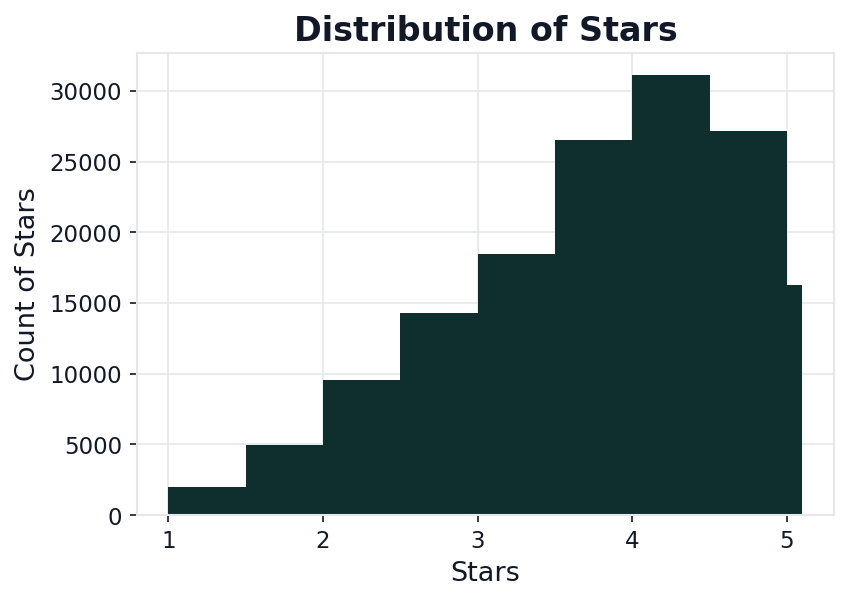

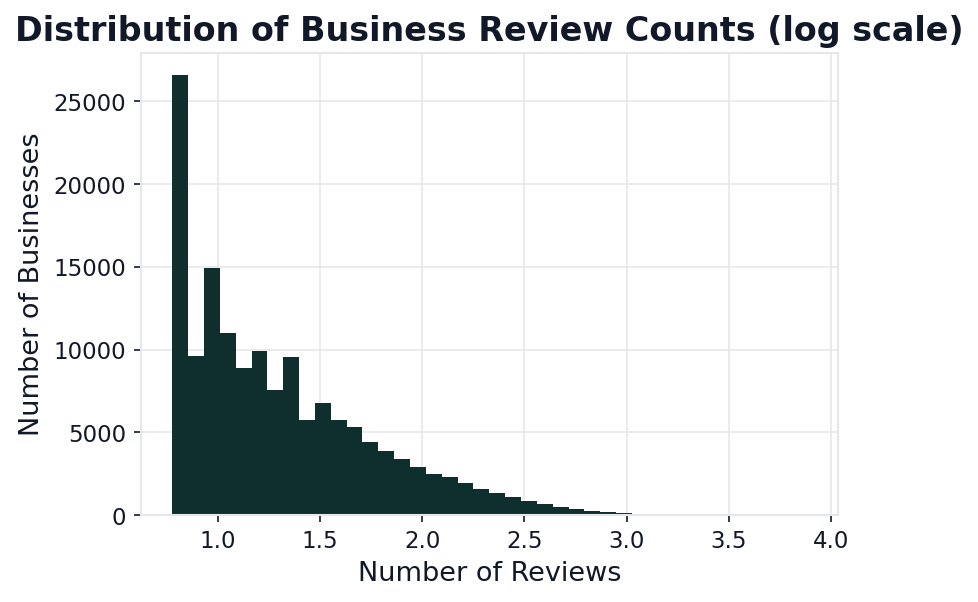

,coverage
accepts_credit_cards,0.796110
parking_any,0.590678
price,0.567225
takeout,0.384127
wifi,0.378553
good_for_kids,0.354828
delivery,0.348090
outdoor_seating,0.312080
reservations,0.299037
good_for_groups,0.293649


,count
primary_category,
Restaurants,15290
Food,6783
Shopping,5480
Beauty & Spas,4385
Home Services,3793
Automotive,3449
Health & Medical,3058
Local Services,2642
Nightlife,2291


In [69]:
import matplotlib.pyplot as plt

# Stars distribution
plt.figure()
df["stars"].plot(kind="hist", bins=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.1])
plt.title("Distribution of Stars")
plt.xlabel("Stars")
plt.ylabel("Count of Stars")
plt.show()

# Review count (log scale)
plt.figure()
(df["review_count"].clip(lower=0) + 1).apply(np.log10).plot(kind="hist", bins=40)
plt.title("Distribution of Business Review Counts (log scale)")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Businesses")
plt.show()

# Attribute coverage
attrs = ["price","wifi","alcohol","attire","noise_level","weekly_hours",
         "accepts_credit_cards","takeout","delivery","good_for_kids",
         "outdoor_seating","reservations","good_for_groups","parking_any"]
coverage = (1 - df[attrs].isna().mean()).sort_values(ascending=False).to_frame("coverage")
display(coverage)

# Top categories
if "primary_category" in df.columns:
    top_cats = df["primary_category"].value_counts().head(15).to_frame("count")
    display(top_cats)


## Q1 — Performance drivers

**Purpose**: construct an interpretable feature matrix, encode minimal categoricals, and create a train/test split.

**Design**:
- **Numeric**: `review_count` (log1p), `price`, `weekly_hours` (median-imputed).
- **Boolean**: selected service and accessibility flags (0/1, missing→0).
- **Categorical (compact)**: `wifi`, `alcohol`, `attire` (one-hot, limited levels) and top 12 `primary_category` one-hots.
- **Target**: `high_rating` (1 if stars ≥ 4.5, else 0).

### Define target and assess feature completeness

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path

# Target: 1 if stars > 4.5 else 0
df["high_rating"] = (df["stars"] > 4.5).astype("int8")

# Base rate
base_rate = df["high_rating"].mean()
print(f"Base rate (stars > 4.5): {base_rate:.3f}")

# Key attributes to audit
key_attrs = [
    "price","wifi","alcohol","attire","noise_level","weekly_hours",
    "accepts_credit_cards","takeout","delivery","good_for_kids",
    "outdoor_seating","reservations","good_for_groups","has_tv",
    "table_service","wheelchair_accessible","dogs_allowed",
    "bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]

present = [c for c in key_attrs if c in df.columns]
coverage = (1 - df[present].isna().mean()).sort_values(ascending=False).to_frame("coverage")
display(coverage)

zero_cov = coverage.index[coverage["coverage"] == 0.0].tolist()
print("Zero-coverage fields:", zero_cov if zero_cov else "None")


Base rate (stars > 4.5): 0.108


,coverage
accepts_credit_cards,0.796110
price,0.567225
takeout,0.384127
wifi,0.378553
good_for_kids,0.354828
delivery,0.348090
outdoor_seating,0.312080
has_tv,0.299742
reservations,0.299037
good_for_groups,0.293649


Zero-coverage fields: ['parking_any', 'parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet']


### Remediate parking_* (extract from raw JSON) and recompute coverage

In [25]:
import ast
import gc
from pathlib import Path
import pandas as pd
import numpy as np

# Locate the raw Yelp business JSON if not already available
try:
    BUSINESS_JSON_PATH
    assert Path(BUSINESS_JSON_PATH).exists()
except Exception:
    # Fallback discovery
    PROJECT_ROOT = Path.cwd()
    CANDIDATE_DIRS = [
        PROJECT_ROOT,
        PROJECT_ROOT / "Yelp-JSON" / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "yelp_dataset",
        PROJECT_ROOT / "data",
    ]
    fname = "yelp_academic_dataset_business.json"
    BUSINESS_JSON_PATH = None
    for base in CANDIDATE_DIRS:
        p = base / fname
        if p.exists():
            BUSINESS_JSON_PATH = p.resolve()
            break
        if base.exists():
            hits = list(base.rglob(fname))
            if hits:
                BUSINESS_JSON_PATH = hits[0].resolve()
                break
    assert BUSINESS_JSON_PATH is not None and Path(BUSINESS_JSON_PATH).exists(), \
        "Raw business JSON not found. Ensure the path is set."

def _parse_str_or_dict(obj):
    """Return a dict if obj is a dict or a stringified dict. Otherwise return None."""
    if isinstance(obj, dict):
        return obj
    if isinstance(obj, str) and obj.strip().startswith("{") and obj.strip().endswith("}"):
        try:
            return ast.literal_eval(obj)
        except Exception:
            return None
    return None

def _extract_parking_from_attributes(attr_obj):
    """
    Extract parking subkeys from attributes. Handle dicts and stringified dicts.
    Return dict with parking_* fields and parking_any.
    """
    out = {
        "parking_garage": None,
        "parking_street": None,
        "parking_validated": None,
        "parking_lot": None,
        "parking_valet": None,
        "parking_any": None,
    }
    if attr_obj is None:
        return out

    # If the entire attributes field is stringified, de-stringify
    attrs = _parse_str_or_dict(attr_obj)
    if not isinstance(attrs, dict):
        return out

    # BusinessParking may itself be a nested string or dict
    bp = attrs.get("BusinessParking", None)
    bp = _parse_str_or_dict(bp)
    if not isinstance(bp, dict):
        return out

    # Coerce common truthy/falsey strings
    def _cbool(x):
        if x in (True, False):
            return bool(x)
        if x is None:
            return None
        s = str(x).strip().lower()
        if s in {"true", "yes", "y", "1"}:
            return True
        if s in {"false", "no", "n", "0"}:
            return False
        return None

    for key in ["garage", "street", "validated", "lot", "valet"]:
        out[f"parking_{key}"] = _cbool(bp.get(key))

    any_true = any(v is True for v in [
        out["parking_garage"], out["parking_street"], out["parking_validated"],
        out["parking_lot"], out["parking_valet"]
    ])
    any_false = any(v is False for v in [
        out["parking_garage"], out["parking_street"], out["parking_validated"],
        out["parking_lot"], out["parking_valet"]
    ])
    out["parking_any"] = True if any_true else (False if (any_false and not any_true) else None)
    return out

# Build enrichment table from raw JSON in chunks
OUTPUTS_DIR = Path.cwd() / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)
enrich_csv = OUTPUTS_DIR / "parking_enrichment.csv"
if enrich_csv.exists():
    enrich_csv.unlink()

written = 0
for raw_chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
    sub = raw_chunk[["business_id", "attributes"]].copy()
    part = sub["attributes"].apply(_extract_parking_from_attributes).apply(pd.Series)
    part.insert(0, "business_id", sub["business_id"].values)

    mode = "w" if written == 0 else "a"
    header = (written == 0)
    part.to_csv(enrich_csv, index=False, mode=mode, header=header)

    written += len(part)
    del raw_chunk, sub, part
    gc.collect()

# Merge enrichment back into the current df
enrich = pd.read_csv(enrich_csv)
merge_cols = ["parking_garage","parking_street","parking_validated","parking_lot","parking_valet","parking_any"]
df = df.drop(columns=[c for c in merge_cols if c in df.columns], errors="ignore").merge(
    enrich[["business_id"] + merge_cols], on="business_id", how="left"
)

# Recompute coverage for key attributes
key_attrs = [
    "price","wifi","alcohol","attire","noise_level","weekly_hours",
    "accepts_credit_cards","takeout","delivery","good_for_kids",
    "outdoor_seating","reservations","good_for_groups","has_tv",
    "table_service","wheelchair_accessible","dogs_allowed",
    "bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
present = [c for c in key_attrs if c in df.columns]
coverage_after = (1 - df[present].isna().mean()).sort_values(ascending=False).to_frame("coverage")

print("Coverage after parking remediation:")
display(coverage_after.loc[[c for c in coverage_after.index if c.startswith("parking_")]])


Coverage after parking remediation:


,coverage
parking_any,0.590678
parking_valet,0.590604
parking_garage,0.577900
parking_validated,0.576364
parking_lot,0.575446
parking_street,0.568515


### Initial association scan (target-rate lift and correlations)

In [26]:
import numpy as np
import pandas as pd
from IPython.display import display

assert "high_rating" in df.columns, "Define target first (Step 1)."

base_rate = df["high_rating"].mean()
print(f"Base rate (stars > 4.5): {base_rate:.3f}")

# A) Binary attributes: target-rate lift 
binary_cols = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
binary_cols = [c for c in binary_cols if c in df.columns]

rows = []
for c in binary_cols:
    s = df[c]
    # treat only True/False observations; ignore missing
    m_true = s == True
    m_false = s == False
    n1 = int(m_true.sum())
    n0 = int(m_false.sum())
    rate1 = df.loc[m_true, "high_rating"].mean() if n1 > 0 else np.nan
    rate0 = df.loc[m_false, "high_rating"].mean() if n0 > 0 else np.nan
    lift_vs_base = (rate1 - base_rate) if pd.notna(rate1) else np.nan
    delta_1_minus_0 = (rate1 - rate0) if pd.notna(rate1) and pd.notna(rate0) else np.nan
    rows.append({
        "feature": c,
        "n_true": n1,
        "n_false": n0,
        "pos_rate_when_true": rate1,
        "pos_rate_when_false": rate0,
        "lift_vs_base_when_true": lift_vs_base,
        "delta_true_minus_false": delta_1_minus_0,
    })

binary_lift = pd.DataFrame(rows)
# Filter very small groups to reduce noise
binary_lift = binary_lift[(binary_lift["n_true"] >= 100) & (binary_lift["n_false"] >= 100)]
binary_lift = binary_lift.sort_values("delta_true_minus_false", ascending=False).reset_index(drop=True)

print("\nBinary attributes — strongest positive deltas (top 12):")
display(binary_lift.head(12))

print("\nBinary attributes — strongest negative deltas (top 12):")
display(binary_lift.tail(12).sort_values("delta_true_minus_false"))

# B) Categorical attributes: one-vs-rest lift by level
def cat_lift_table(col: str, min_count: int = 200) -> pd.DataFrame:
    s = df[col].fillna("Unknown")
    g = df.groupby(s)["high_rating"].agg(["mean", "count"]).rename(columns={"mean": "pos_rate", "count": "n"})
    g = g[g["n"] >= min_count].copy()
    g["lift_vs_base"] = g["pos_rate"] - base_rate
    g = g.sort_values("lift_vs_base", ascending=False).reset_index().rename(columns={col: "level"})
    g.insert(0, "feature", col)
    return g

cat_cols = [c for c in ["wifi","alcohol","attire"] if c in df.columns]

cat_tables = []
for c in cat_cols:
    tbl = cat_lift_table(c, min_count=200)
    cat_tables.append(tbl)

for c, tbl in zip(cat_cols, cat_tables):
    print(f"\nCategorical attribute: {c} — levels by lift (top 10):")
    display(tbl.head(10))

# C) Numeric features: point-biserial correlations and simple summaries 
num_cols = [c for c in ["review_count", "price", "weekly_hours"] if c in df.columns]
# add log1p(review_count) for robustness
if "review_count" in df.columns:
    df["_review_count_log1p_tmp"] = np.log1p(df["review_count"].clip(lower=0))
    num_cols.append("_review_count_log1p_tmp")

rows_n = []
y = df["high_rating"].astype(float)
for c in num_cols:
    s = df[c]
    m = s.notna() & y.notna()
    if m.sum() < 100:
        continue
    x = s[m].astype(float)
    yt = y[m]
    corr = np.corrcoef(x, yt)[0, 1]
    rows_n.append({"feature": c, "n": int(m.sum()), "point_biserial_corr": corr})

num_corr = pd.DataFrame(rows_n).sort_values("point_biserial_corr", ascending=False)
print("\nNumeric features — point-biserial correlations:")
display(num_corr)

# clean up temporary column
if "_review_count_log1p_tmp" in df.columns:
    df.drop(columns=["_review_count_log1p_tmp"], inplace=True)


Base rate (stars > 4.5): 0.108

Binary attributes — strongest positive deltas (top 12):


,feature,n_true,n_false,pos_rate_when_true,pos_rate_when_false,lift_vs_base_when_true,delta_true_minus_false
0,bitcoin,470,16957,0.270213,0.158872,0.161750,0.111340
1,dogs_allowed,5991,12267,0.129528,0.062525,0.021064,0.067002
2,parking_street,23026,62448,0.095414,0.068153,-0.013049,0.027261
3,outdoor_seating,22549,24371,0.030733,0.020968,-0.077730,0.009766
4,parking_any,62754,26052,0.073493,0.075119,-0.034970,-0.001626
5,parking_garage,4140,82745,0.070773,0.074893,-0.037690,-0.004120
6,reservations,14854,30105,0.016696,0.021292,-0.091767,-0.004596
7,parking_validated,839,85815,0.069130,0.074754,-0.039333,-0.005624
8,delivery,32146,20188,0.031979,0.037696,-0.076484,-0.005717
9,good_for_groups,38148,6001,0.013579,0.021330,-0.094884,-0.007751



Binary attributes — strongest negative deltas (top 12):


,feature,n_true,n_false,pos_rate_when_true,pos_rate_when_false,lift_vs_base_when_true,delta_true_minus_false
19,wheelchair_accessible,25993,2933,0.124187,0.251620,0.015724,-0.127432
18,accepts_credit_cards,113667,6025,0.100179,0.197178,-0.008285,-0.097000
17,parking_valet,1458,87337,0.024691,0.074802,-0.083772,-0.050111
16,happy_hour,9721,5448,0.016459,0.051946,-0.092004,-0.035486
15,takeout,52943,4809,0.033357,0.064462,-0.075107,-0.031106
14,table_service,12674,7293,0.022960,0.050048,-0.085503,-0.027088
13,has_tv,34154,10911,0.016777,0.040510,-0.091686,-0.023733
12,drive_thru,4374,2631,0.006173,0.024705,-0.102290,-0.018533
11,parking_lot,44247,42269,0.069248,0.080745,-0.039216,-0.011497
10,good_for_kids,43905,9442,0.045462,0.056768,-0.063001,-0.011306



Categorical attribute: wifi — levels by lift (top 10):


,feature,level,pos_rate,n,lift_vs_base
0,wifi,Unknown,0.130544,93432,0.022081
1,wifi,paid,0.127625,619,0.019162
2,wifi,free,0.077904,34414,-0.030559
3,wifi,no,0.061564,21831,-0.046899



Categorical attribute: alcohol — levels by lift (top 10):


,feature,level,pos_rate,n,lift_vs_base
0,alcohol,Unknown,0.142996,107157,0.034533
1,alcohol,none,0.030934,20948,-0.077529
2,alcohol,beer_wine,0.029285,6249,-0.079178
3,alcohol,full_bar,0.009567,15992,-0.098896



Categorical attribute: attire — levels by lift (top 10):


,feature,level,pos_rate,n,lift_vs_base
0,attire,Unknown,0.142793,111091,0.034330
1,attire,casual,0.011449,38344,-0.097014
2,attire,dressy,0.006227,803,-0.102236



Numeric features — point-biserial correlations:


,feature,n,point_biserial_corr
1,price,85280,0.037092
0,review_count,150346,-0.081797
2,weekly_hours,7653,-0.093974
3,_review_count_log1p_tmp,150346,-0.181357


### Segment baseline: base rates and coverage by top categories

In [28]:
# Segment baseline: base rates and coverage by top primary categories

import pandas as pd
import numpy as np
from pathlib import Path

assert "high_rating" in df.columns, "Define target first."

# Choose the top N primary categories by count (add 'Other' as a catch-all)
TOP_N = 8
seg_levels = df["primary_category"].value_counts().head(TOP_N).index.tolist()
df_seg = df.copy()
df_seg["segment"] = np.where(df_seg["primary_category"].isin(seg_levels),
                             df_seg["primary_category"], "Other")

# Attributes we can audit across segments (broadly applicable)
attrs = [
    "price","wifi","alcohol","attire","noise_level","weekly_hours",
    "accepts_credit_cards","takeout","delivery","good_for_kids",
    "outdoor_seating","reservations","good_for_groups","has_tv",
    "wheelchair_accessible","table_service","dogs_allowed",
    "bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet"
]
attrs = [c for c in attrs if c in df_seg.columns]  # keep only present

# Build segment baseline table
rows = []
for seg, g in df_seg.groupby("segment", dropna=False):
    row = {
        "segment": seg,
        "n": len(g),
        "base_rate_high": g["high_rating"].mean(),  # stars > 4.5
    }
    # Coverage per attribute
    for a in attrs:
        row[f"cov__{a}"] = (1 - g[a].isna().mean())
    rows.append(row)

seg_table = pd.DataFrame(rows).sort_values("n", ascending=False).reset_index(drop=True)

# Save for reference
out_path = Path.cwd() / "outputs" / "q1_segment_baseline_coverage.csv"
seg_table.to_csv(out_path, index=False)

display(seg_table.head(10))


,segment,n,base_rate_high,cov__price,cov__wifi,cov__alcohol,cov__attire,cov__noise_level,cov__weekly_hours,cov__accepts_credit_cards,cov__takeout,cov__delivery,cov__good_for_kids,cov__outdoor_seating,cov__reservations,cov__good_for_groups,cov__has_tv,cov__wheelchair_accessible,cov__table_service,cov__dogs_allowed,cov__bitcoin,cov__happy_hour,cov__drive_thru,cov__parking_any,cov__parking_garage,cov__parking_street,cov__parking_validated,cov__parking_lot,cov__parking_valet
0,Other,105466,0.112833,0.541502,0.374509,0.278905,0.243396,0.243652,0.051732,0.775567,0.354626,0.323592,0.353412,0.299253,0.285021,0.281550,0.290767,0.197912,0.129824,0.126922,0.117763,0.106148,0.043350,0.571957,0.559602,0.551258,0.558161,0.557706,0.571919
1,Restaurants,15290,0.026422,0.853107,0.691498,0.758404,0.768018,0.664552,0.051275,0.859712,0.915239,0.865337,0.804774,0.803139,0.829235,0.812950,0.798300,0.209549,0.345389,0.181360,0.097711,0.204840,0.104774,0.844931,0.818901,0.799215,0.816678,0.812884,0.844931
2,Food,6783,0.073419,0.850803,0.519387,0.304143,0.262126,0.284682,0.032729,0.868200,0.800236,0.597966,0.323898,0.426360,0.304585,0.283945,0.299278,0.237653,0.134159,0.169836,0.110423,0.107032,0.086687,0.877783,0.849182,0.820139,0.844317,0.838862,0.877340
3,Shopping,5480,0.114051,0.798905,0.060219,0.013504,0.006387,0.010766,0.029380,0.875547,0.092336,0.091606,0.056934,0.022080,0.017701,0.012409,0.018613,0.235219,0.009854,0.124270,0.115146,0.014416,0.025730,0.791971,0.788686,0.784307,0.787774,0.788139,0.791971
4,Beauty & Spas,4385,0.152794,0.808210,0.271152,0.001140,0.000912,0.018016,0.074116,0.885291,0.022121,0.022121,0.246978,0.005245,0.005017,0.001140,0.004789,0.284379,0.003421,0.012543,0.120639,0.004333,0.010490,0.829418,0.828278,0.827138,0.826910,0.827138,0.828734
5,Home Services,3793,0.173741,0.058529,0.020828,0.001846,0.000527,0.000527,0.041656,0.824413,0.013709,0.014764,0.003955,0.002109,0.001582,0.001055,0.001846,0.058265,0.000791,0.016873,0.237279,0.001318,0.000791,0.060374,0.060374,0.060111,0.060374,0.060374,0.060374
6,Automotive,3449,0.142940,0.039722,0.210786,0.002899,0.003769,0.002609,0.057408,0.766309,0.051319,0.047260,0.007538,0.003479,0.003769,0.003189,0.003769,0.007538,0.000580,0.004059,0.014207,0.001160,0.005509,0.046680,0.046680,0.046100,0.046390,0.046390,0.046680
7,Health & Medical,3058,0.182472,0.147482,0.220405,0.002289,0.001308,0.002943,0.073250,0.704382,0.019948,0.019621,0.026161,0.003597,0.002616,0.001308,0.003270,0.090255,0.001962,0.013407,0.043165,0.001635,0.010464,0.182472,0.181818,0.181491,0.181818,0.182145,0.182145
8,Local Services,2642,0.189251,0.235806,0.121499,0.004542,0.002271,0.002650,0.047313,0.854656,0.013626,0.015519,0.021196,0.004542,0.003028,0.002650,0.003785,0.067373,0.001514,0.034822,0.197956,0.001514,0.000757,0.259652,0.259273,0.259273,0.259273,0.259652,0.259652


### Create and merge macro-segments

In [29]:
# Q1 — Macro-segment mapping from raw Yelp categories, merge into df, and summarize

import re, gc, ast
from pathlib import Path
import pandas as pd
import numpy as np

# Ensure df is loaded and target exists
try:
    assert "business_id" in df.columns and "high_rating" in df.columns
except AssertionError:
    raise RuntimeError("Load cleaned business CSV and define `high_rating` before running this cell.")

# Locate raw business JSON if not already set
try:
    BUSINESS_JSON_PATH
    assert Path(BUSINESS_JSON_PATH).exists()
except Exception:
    PROJECT_ROOT = Path.cwd()
    CANDIDATE_DIRS = [
        PROJECT_ROOT,
        PROJECT_ROOT / "Yelp-JSON" / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "yelp_dataset",
        PROJECT_ROOT / "data",
    ]
    fname = "yelp_academic_dataset_business.json"
    BUSINESS_JSON_PATH = None
    for base in CANDIDATE_DIRS:
        p = base / fname
        if p.exists():
            BUSINESS_JSON_PATH = p.resolve()
            break
        if base.exists():
            hits = list(base.rglob(fname))
            if hits:
                BUSINESS_JSON_PATH = hits[0].resolve()
                break
    assert BUSINESS_JSON_PATH is not None and Path(BUSINESS_JSON_PATH).exists(), \
        "Raw business JSON not found."

# ----- Define macro-segments with keyword lists (lowercase substrings) -----
SEGMENTS = [
    ("Food & Beverage", [
        "restaurant","food","nightlife","bar","pub","brewpub","beer",
        "wine","cocktail","coffee","tea","cafe","bakery","dessert",
        "ice cream","frozen yogurt","pizza","sandwich","burger","bbq",
        "steak","seafood","sushi","ramen","noodle",
        "chinese","japanese","italian","mexican","thai","indian","korean",
        "mediterranean","middle eastern","greek","vietnamese","juice","smoothie"
    ]),
    ("Beauty & Wellness", [
        "beauty & spas","spa","massage","hair","barbers","nail","laser hair removal",
        "skin care","day spas","waxing","cosmetics","eyelash service","medical spas"
    ]),
    ("Health & Medical", [
        "health & medical","dentist","dental","doctor","optometrist","ophthalmologist",
        "chiropractor","urgent care","hospital","clinic","physician","orthodontist","dermatologist",
        "physical therapy","pharmacy","nutritionist"
    ]),
    ("Home & Local Services", [
        "home services","contractor","plumbing","electrician","hvac","landscaping",
        "local services","keys","locksmith","laundry services","handyman","cleaning","appliances repair"
    ]),
    ("Shopping & Retail", [
        "shopping","retail","department store","fashion","books","toys","electronics",
        "furniture","home decor","jewelry","shoe stores","gift shops","pet store"
    ]),
    ("Automotive", [
        "automotive","auto repair","car dealers","oil change","car wash","smog check",
        "tires","body shops","windshield"
    ]),
    ("Professional Services", [
        "professional services","lawyers","legal services","real estate","mortgage brokers",
        "insurance","financial services","tax services","accountants","it services","marketing"
    ]),
    ("Entertainment & Events", [
        "arts & entertainment","event planning & services","venues & event spaces",
        "performing arts","music venues","party & event planning","photographers","caterers"
    ]),
    ("Travel & Hospitality", [
        "hotels","travel services","vacation rentals","resorts","hostels","transportation","airport shuttles"
    ]),
    ("Education & Public Services", [
        "education","tutoring","driving schools","religious organizations","public services & government",
        "libraries","community service/non-profit","university","college","school"
    ]),
    ("Pets", [
        "pet services","veterinarians","pet groomers","dog walkers","pet boarding"
    ]),
]

# Priority order is top-to-bottom in SEGMENTS
def map_macro_segment(categories_str: str) -> str:
    if not isinstance(categories_str, str) or not categories_str.strip():
        return "Other"
    s = categories_str.lower()
    for seg, keywords in SEGMENTS:
        for kw in keywords:
            if kw in s:
                return seg
    return "Other"

# ----- Build mapping by streaming raw JSON (business_id -> macro_segment) -----
OUTPUTS_DIR = Path.cwd() / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)
map_csv = OUTPUTS_DIR / "q1_macro_segments.csv"

# Recompute fresh each run to be deterministic
if map_csv.exists():
    map_csv.unlink()

written = 0
for chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
    part = chunk[["business_id","categories"]].copy()
    part["macro_segment"] = part["categories"].apply(map_macro_segment)
    mode = "w" if written == 0 else "a"; header = (written == 0)
    part[["business_id","macro_segment"]].to_csv(map_csv, index=False, mode=mode, header=header)
    written += len(part)
    del chunk, part
    gc.collect()

# ----- Merge into working df and summarize -----
seg_map = pd.read_csv(map_csv)
df = df.drop(columns=["macro_segment"], errors="ignore").merge(seg_map, on="business_id", how="left")
df["macro_segment"] = df["macro_segment"].fillna("Other")

seg_summary = (
    df.groupby("macro_segment", dropna=False)
      .agg(n=("business_id","size"), base_rate_high=("high_rating","mean"))
      .sort_values("n", ascending=False).reset_index()
)

print("Macro-segment mapping complete. Saved: outputs/q1_macro_segments.csv")
display(seg_summary)


Macro-segment mapping complete. Saved: outputs/q1_macro_segments.csv


,macro_segment,n,base_rate_high
0,Food & Beverage,71515,0.052255
1,Home & Local Services,21119,0.172215
2,Beauty & Wellness,13702,0.166326
3,Shopping & Retail,12878,0.120826
4,Automotive,8698,0.141067
5,Health & Medical,8627,0.156022
6,Entertainment & Events,4281,0.171689
7,Other,3647,0.198794
8,Pets,2227,0.179614
9,Professional Services,1558,0.192555


### Food & Beverage: univariate screening

In [ ]:
# Q1 / Segment = Food & Beverage — univariate screening (lifts, effect sizes), save results

import numpy as np
import pandas as pd
from pathlib import Path

# Segment subset
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, f"No rows for segment: {SEG}"
base = df_s["high_rating"].mean()

OUT_FB = Path.cwd() / "outputs"/"food_&_beverage"
OUT_FB.mkdir(exist_ok=True)

# ---------- Helpers ----------
def _phi_2x2(a,b,c,d):
    num = (a*d) - (b*c)
    den = np.sqrt((a+b)*(c+d)*(a+c)*(b+d))
    return float(num/den) if den else np.nan

def _odds_ratio_ci(a,b,c,d, alpha=0.05):
    # continuity correction for zeros
    a,b,c,d = [x if x>0 else 0.5 for x in (a,b,c,d)]
    or_ = (a*d)/(b*c)
    se  = np.sqrt(1/a + 1/b + 1/c + 1/d)
    z   = 1.96  # 95% CI
    lo, hi = np.exp(np.log(or_) - z*se), np.exp(np.log(or_) + z*se)
    return float(or_), float(lo), float(hi)

# ---------- A) Binary attributes ----------
BIN_COLS = [
    "accepts_credit_cards","takeOUT_FB","delivery","good_for_kids","OUT_FBdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
BIN_COLS = [c for c in BIN_COLS if c in df_s.columns]

bin_rows = []
for c in BIN_COLS:
    s = df_s[c]
    m = s.isin([True, False])
    if m.sum() < 2000:  # guardrail
        continue
    y = df_s.loc[m, "high_rating"].astype(int)
    x = s[m].astype(bool)

    n_true, n_false = int((x==True).sum()), int((x==False).sum())
    if n_true < 500 or n_false < 500:
        continue

    a = int(((x==True)  & (y==1)).sum())
    b = int(((x==True)  & (y==0)).sum())
    c0 = int(((x==False) & (y==1)).sum())
    d  = int(((x==False) & (y==0)).sum())

    r_true  = a / (a+b) if (a+b)>0 else np.nan
    r_false = c0 / (c0+d) if (c0+d)>0 else np.nan

    phi = _phi_2x2(a,b,c0,d)
    or_, lo, hi = _odds_ratio_ci(a,b,c0,d)

    bin_rows.append({
        "feature": c,
        "n_true": n_true, "n_false": n_false,
        "pos_rate_true": r_true, "pos_rate_false": r_false,
        "lift_true_vs_base_pp": r_true - base,
        "delta_true_minus_false_pp": r_true - r_false,
        "phi": phi,
        "odds_ratio": or_, "or_ci_lo": lo, "or_ci_hi": hi
    })

bin_tbl = (pd.DataFrame(bin_rows)
           .sort_values("delta_true_minus_false_pp", ascending=False)
           .reset_index(drop=True))

# ---------- B) Categorical levels (wifi, alcohol, attire) ----------
def level_lifts(df_in, col, min_n=1000):
    s = df_in[col].fillna("Unknown")
    counts = s.value_counts()
    keep = counts[counts >= min_n].index
    OUT_FB = []
    for lvl in keep:
        mask = (s == lvl)
        a = int((mask & (df_in["high_rating"]==1)).sum())
        b = int((mask & (df_in["high_rating"]==0)).sum())
        c0 = int((~mask & (df_in["high_rating"]==1)).sum())
        d  = int((~mask & (df_in["high_rating"]==0)).sum())
        n = a + b
        if n < min_n:
            continue
        r_lvl = a / (a+b) if (a+b)>0 else np.nan
        r_rest = c0 / (c0+d) if (c0+d)>0 else np.nan
        phi = _phi_2x2(a,b,c0,d)
        or_, lo, hi = _odds_ratio_ci(a,b,c0,d)
        OUT_FB.append({
            "feature": col, "level": lvl, "n": n,
            "pos_rate": r_lvl,
            "lift_vs_base_pp": r_lvl - base,
            "delta_vs_rest_pp": r_lvl - r_rest,
            "phi": phi,
            "odds_ratio": or_, "or_ci_lo": lo, "or_ci_hi": hi
        })
    return (pd.DataFrame(OUT_FB)
            .sort_values(["lift_vs_base_pp","delta_vs_rest_pp"], ascending=False)
            .reset_index(drop=True))

cat_results = {}
for cat in [c for c in ["wifi","alcohol","attire"] if c in df_s.columns]:
    cat_results[cat] = level_lifts(df_s, cat, min_n=1000)

# ---------- C) Numeric / ordinal ----------
num_rows = []
for c in [x for x in ["review_count","price","weekly_hours"] if x in df_s.columns]:
    s = df_s[c]
    m = s.notna()
    if m.sum() < 1000:
        continue
    x = s[m].astype(float)
    y = df_s.loc[m, "high_rating"].astype(float)
    # point-biserial via Pearson(x,y)
    r_pb = np.corrcoef(x, y)[0,1]
    # Spearman (monotonic trend)
    r_sp = pd.Series(x).rank().corr(pd.Series(y).rank(), method="pearson")
    num_rows.append({"feature": c, "n": int(m.sum()),
                     "point_biserial": r_pb, "spearman": r_sp})
# log1p(review_count)
if "review_count" in df_s.columns:
    x = np.log1p(df_s["review_count"].clip(lower=0))
    r_pb = np.corrcoef(x, df_s["high_rating"].astype(float))[0,1]
    num_rows.append({"feature": "review_count_log1p", "n": len(x),
                     "point_biserial": r_pb, "spearman": pd.Series(x).rank().corr(pd.Series(df_s["high_rating"]).rank())})

num_tbl = pd.DataFrame(num_rows).sort_values("point_biserial", ascending=False)

# ---------- Save + preview ----------
bin_path = OUT_FB / "q1_FB_screen_binary.csv"
num_path = OUT_FB / "q1_FB_screen_numeric.csv"
bin_tbl.to_csv(bin_path, index=False)
num_tbl.to_csv(num_path, index=False)
for cat, tbl in cat_results.items():
    tbl.to_csv(OUT_FB / f"q1_FB_screen_{cat}.csv", index=False)

print(f"Saved: {bin_path.name}, {num_path.name}, and categorical files in outputs/")
print(f"Base rate (segment): {base:.3f}")

print("\nBinary — strongest positives (top 10):")
display(bin_tbl.head(10))

print("\nBinary — strongest negatives (top 10):")
display(bin_tbl.tail(10).sort_values("delta_true_minus_false_pp"))

for cat in cat_results:
    print(f"\nCategorical ({cat}) — top levels by lift (support ≥ 1,000):")
    display(cat_results[cat].head(10))

print("\nNumeric / ordinal (sorted by point-biserial):")
display(num_tbl)


Saved: q1_FB_screen_binary.csv, q1_FB_screen_numeric.csv, and categorical files in OUT_FBputs/
Base rate (segment): 0.052

Binary — strongest positives (top 10):


,feature,n_true,n_false,pos_rate_true,pos_rate_false,lift_true_vs_base_pp,delta_true_minus_false_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
0,dogs_allowed,3741,10132,0.082331,0.039676,0.030076,0.042655,0.085902,2.171519,1.862632,2.531631
1,parking_street,16604,40196,0.052397,0.037267,0.000142,0.015130,0.034428,1.428423,1.311266,1.556047
2,good_for_kids,36817,7080,0.020127,0.021610,-0.032128,-0.001484,-0.003863,0.929937,0.779911,1.108823
3,parking_validated,617,57353,0.037277,0.041253,-0.014978,-0.003976,-0.002053,0.899884,0.592122,1.367610
4,reservations,14786,29926,0.016434,0.021219,-0.035820,-0.004785,-0.016223,0.770749,0.663935,0.894746
5,delivery,31671,19287,0.030059,0.036605,-0.022196,-0.006546,-0.017894,0.815632,0.738725,0.900546
6,parking_garage,2876,55308,0.034423,0.041676,-0.017832,-0.007253,-0.007899,0.819764,0.667979,1.006039
7,good_for_groups,38120,5999,0.013536,0.021337,-0.038719,-0.007801,-0.022294,0.629387,0.517631,0.765271
8,parking_any,44102,15995,0.038842,0.048078,-0.013413,-0.009236,-0.020513,0.800136,0.733415,0.872926
9,parking_lot,30529,27309,0.035999,0.047274,-0.016256,-0.011275,-0.028281,0.752584,0.693227,0.817023



Binary — strongest negatives (top 10):


,feature,n_true,n_false,pos_rate_true,pos_rate_false,lift_true_vs_base_pp,delta_true_minus_false_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
16,wheelchair_accessible,16609,1552,0.073996,0.161727,0.021741,-0.087731,-0.089645,0.414190,0.357537,0.479818
15,accepts_credit_cards,58891,2392,0.044251,0.108278,-0.008004,-0.064026,-0.058739,0.381305,0.333213,0.436338
14,happy_hour,9720,5209,0.016461,0.052793,-0.035794,-0.036332,-0.102959,0.300281,0.246369,0.365991
13,parking_valet,1260,58833,0.011905,0.041932,-0.040350,-0.030027,-0.021620,0.275277,0.165186,0.458739
12,table_service,12671,7174,0.022966,0.050181,-0.029289,-0.027215,-0.073405,0.444910,0.380148,0.520704
11,has_tv,34137,10674,0.016756,0.040378,-0.035499,-0.023622,-0.068026,0.405004,0.356715,0.459830
10,drive_thru,4358,2563,0.005737,0.021069,-0.046518,-0.015332,-0.069699,0.268076,0.166433,0.431794
9,parking_lot,30529,27309,0.035999,0.047274,-0.016256,-0.011275,-0.028281,0.752584,0.693227,0.817023
8,parking_any,44102,15995,0.038842,0.048078,-0.013413,-0.009236,-0.020513,0.800136,0.733415,0.872926
7,good_for_groups,38120,5999,0.013536,0.021337,-0.038719,-0.007801,-0.022294,0.629387,0.517631,0.765271



Categorical (wifi) — top levels by lift (support ≥ 1,000):


,feature,level,n,pos_rate,lift_vs_base_pp,delta_vs_rest_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
0,wifi,Unknown,27561,0.079859,0.027604,0.044914,0.098224,2.396789,2.241474,2.562865
1,wifi,free,24754,0.038054,-0.014200,-0.021718,-0.046427,0.622286,0.577029,0.671093
2,wifi,no,18859,0.030542,-0.021712,-0.029489,-0.058389,0.493301,0.450662,0.539974



Categorical (alcohol) — top levels by lift (support ≥ 1,000):


,feature,level,n,pos_rate,lift_vs_base_pp,delta_vs_rest_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
0,alcohol,Unknown,28390,0.097076,0.044822,0.074329,0.163417,4.618804,4.287189,4.976070
1,alcohol,none,20913,0.030890,-0.021365,-0.030195,-0.061719,0.489935,0.449394,0.534132
2,alcohol,beer_wine,6237,0.029341,-0.022914,-0.025103,-0.031827,0.524983,0.451452,0.610491
3,alcohol,full_bar,15975,0.009515,-0.042740,-0.055033,-0.103001,0.139217,0.118244,0.163910



Categorical (attire) — top levels by lift (support ≥ 1,000):


,feature,level,n,pos_rate,lift_vs_base_pp,delta_vs_rest_pp,phi,odds_ratio,or_ci_lo,or_ci_hi
0,attire,Unknown,32319,0.101952,0.049698,0.090676,0.202785,9.953880,9.002655,11.005613
1,attire,casual,38286,0.011414,-0.040841,-0.087897,-0.196991,0.104714,0.094662,0.115834



Numeric / ordinal (sorted by point-biserial):


,feature,n,point_biserial,spearman
1,price,58694,-0.005280,-0.004490
0,review_count,71515,-0.065679,-0.153025
2,weekly_hours,3136,-0.091961,-0.094240
3,review_count_log1p,71515,-0.143691,-0.153025


### Food & Beverage — multivariate driver ranking with Elastic Net

In [33]:


import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn import __version__ as sklver

# Output folder (nested)
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# --- Segment data
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"

# --- Feature set with coverage filter (>= 0.30 within segment)
ALL_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_any","parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
ALL_CAT  = ["wifi","alcohol","attire"]
NUM_BASE = ["review_count","price","weekly_hours"]

cov = (1 - df_s[ALL_BOOL + ALL_CAT + NUM_BASE].isna().mean()).rename("coverage")
BOOL_COLS = [c for c in ALL_BOOL if cov.get(c,0) >= 0.30]
CAT_COLS  = [c for c in ALL_CAT  if cov.get(c,0) >= 0.30]
_num_cov  = cov.reindex(NUM_BASE).fillna(0.0)
NUM_COLS  = ["price"] if _num_cov.get("price",0) >= 0.30 else []  # weekly_hours sparse; review_count handled separately

# Target and numeric transform
df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"] + NUM_COLS

# Control for subcategory mix: top 12 primary_category within segment
topK = 12
top_primary = df_s["primary_category"].value_counts().head(topK).index.tolist()
df_s["primary_category_top"] = np.where(df_s["primary_category"].isin(top_primary),
                                        df_s["primary_category"], "Other")
CAT_COLS_ALL = CAT_COLS + ["primary_category_top"]

# Build X/y
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS_ALL]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Version-safe OneHotEncoder
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(handle_unknown="ignore")
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

# Preprocessor
numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
boolean = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
categorical = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                        ("ohe", OneHotEncoder(**ohe_params))])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS_ALL),
    ],
    remainder="drop",
)

# Pipeline + CV tuning
pipe = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# ---- Driver table (clean names, odds ratios, support) ----
feat = best.named_steps["prep"].get_feature_names_out()
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    s = re.sub(r"^(num|bool|cat)__", "", s)
    s = s.replace("primary_category_top_", "category: ")
    s = s.replace("review_count_log1p", "review_count (log1p)")
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Supports
support = {}
for c in BOOL_COLS:
    support[f"bool__{c}"] = float((df_s[c] == True).mean())
for c in CAT_COLS_ALL:
    vc = df_s[c].fillna("Unknown").value_counts(normalize=True)
    for lvl, p in vc.items():
        support[f"cat__{c}_{lvl}"] = float(p)
for c in NUM_COLS:
    support[f"num__{c}"] = float(df_s[c].notna().mean())

drivers["support_share"] = drivers["feature_raw"].map(support).fillna(np.nan)
drivers = (drivers[["feature","coef","odds_ratio","support_share"]]
           .sort_values("coef", ascending=False)
           .reset_index(drop=True))

top_pos = drivers.head(12).copy()
top_neg = drivers.tail(12).sort_values("coef").copy()

# Save to nested folder
out_csv = OUT_FB / "q1_FB_logit_drivers.csv"
drivers.to_csv(out_csv, index=False)


print("\nTop positive drivers:")
display(top_pos)
print("\nTop negative drivers:")
display(top_neg)


Best params: {'lr__C': 0.2, 'lr__penalty': 'l2'}
CV best ROC-AUC: 0.813
Test ROC-AUC   : 0.8178
Test Accuracy  : 0.6784

Classification report:
               precision    recall  f1-score   support

           0      0.985     0.671     0.798     16945
           1      0.120     0.814     0.209       934

    accuracy                          0.678     17879
   macro avg      0.552     0.742     0.504     17879
weighted avg      0.940     0.678     0.767     17879


Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire Unknown,1.467306,4.337535,0.451919
1,parking street,0.820030,2.270567,0.232175
2,category: Mexican,0.581992,1.789599,0.018947
3,wifi none,0.540858,1.717479,0.000531
4,alcohol none,0.525072,1.690581,0.292428
5,category: Other,0.470962,1.601535,0.462882
6,alcohol beer wine,0.432175,1.540605,0.087212
7,category: American (New),0.428225,1.534531,0.017185
8,category: Nightlife,0.347518,1.415550,0.032035
9,outdoor seating,0.296449,1.345074,0.315025



Top negative drivers:


,feature,coef,odds_ratio,support_share
42,category: Fast Food,-1.420887,0.241500,0.019562
41,alcohol full bar,-0.961685,0.382248,0.223380
40,attire formal,-0.753245,0.470836,0.000979
39,good for groups,-0.626856,0.534269,0.533035
38,category: Pizza,-0.597809,0.550015,0.028889
37,parking any,-0.593337,0.552480,0.616682
36,parking valet,-0.561898,0.570126,0.017619
35,attire none,-0.508306,0.601514,0.000531
34,has tv,-0.505289,0.603331,0.477340
33,review count (log1p),-0.464229,0.628619,1.000000


### Cleaning our results further

#### Step 1: drop `parking_any`, pool rare levels, refit logistic

In [34]:


import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, average_precision_score
from sklearn import __version__ as sklver

# Output folder
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# Segment data
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"

# Feature set with coverage filter (>= 0.30 within segment)
ALL_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    # "parking_any",  # dropped by design
    "parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
ALL_CAT  = ["wifi","alcohol","attire"]
NUM_BASE = ["review_count","price","weekly_hours"]

cov = (1 - df_s[ALL_BOOL + ALL_CAT + NUM_BASE].isna().mean()).rename("coverage")
BOOL_COLS = [c for c in ALL_BOOL if cov.get(c,0) >= 0.30]
CAT_COLS  = [c for c in ALL_CAT  if cov.get(c,0)  >= 0.30]

# Numeric features
df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"]
if cov.get("price",0) >= 0.30:
    NUM_COLS += ["price"]

# Control for subcategory mix (kept for now; will replace with cuisine tokens later)
topK = 12
top_primary = df_s["primary_category"].value_counts().head(topK).index.tolist()
df_s["primary_category_top"] = np.where(df_s["primary_category"].isin(top_primary),
                                        df_s["primary_category"], "Other")
CAT_COLS_ALL = CAT_COLS + ["primary_category_top"]

# Build matrices
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS_ALL]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# OneHotEncoder parameters: pool rare levels and handle unknowns
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(
    handle_unknown="infrequent_if_exist",
    min_frequency=0.01,  # pool levels below ~1% share
)
# dense output (version-safe)
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

# Preprocessor
numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
boolean = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(**ohe_params)),
])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS_ALL),
    ],
    remainder="drop",
)

# Pipeline + CV tuning
pipe = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

# Metrics
print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC (AP)    :", round(average_precision_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# Driver table
feat_names = best.named_steps["prep"].get_feature_names_out()
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat_names, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    s = re.sub(r"^(num|bool|cat)(?:__ohe)?__", "", s)  # strip prefixes incl. ohe
    s = s.replace("primary_category_top_", "category: ")
    s = s.replace("review_count_log1p", "review_count (log1p)")
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Supports (share present/True for booleans; level share for categoricals)
support = {}
for c in BOOL_COLS:
    support[f"bool__{c}"] = float((df_s[c] == True).mean())
for c in CAT_COLS_ALL:
    vc = df_s[c].fillna("Unknown").value_counts(normalize=True)
    for lvl, p in vc.items():
        support[f"cat__{c}_{lvl}"] = float(p)
for c in NUM_COLS:
    support[f"num__{c}"] = float(df_s[c].notna().mean())

drivers["support_share"] = drivers["feature_raw"].map(support)  # may be NaN for pooled 'infrequent_sklearn'
drivers = drivers[["feature","coef","odds_ratio","support_share"]].sort_values("coef", ascending=False).reset_index(drop=True)

# Save
out_csv = OUT_FB / "q1_FB_logit_drivers_step1_clean.csv"
drivers.to_csv(out_csv, index=False)


# Preview
print("\nTop positive drivers:")
display(drivers.head(12))
print("\nTop negative drivers:")
display(drivers.tail(12).sort_values("coef"))


Best params: {'lr__C': 0.2, 'lr__penalty': 'l2'}
CV best ROC-AUC: 0.8117
Test ROC-AUC   : 0.8156
PR-AUC (AP)    : 0.1703
Test Accuracy  : 0.6758

Classification report:
               precision    recall  f1-score   support

           0      0.985     0.668     0.796     16945
           1      0.120     0.820     0.209       934

    accuracy                          0.676     17879
   macro avg      0.553     0.744     0.503     17879
weighted avg      0.940     0.676     0.765     17879


Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire Unknown,1.387390,4.004384,0.451919
1,category: Mexican,0.601414,1.824697,0.018947
2,alcohol none,0.522174,1.685689,0.292428
3,category: Other,0.469720,1.599546,0.462882
4,parking street,0.449524,1.567566,0.232175
5,alcohol beer wine,0.433591,1.542789,0.087212
6,category: American (New),0.430210,1.537580,0.017185
7,wifi infrequent sklearn,0.420797,1.523175,NaN
8,category: Nightlife,0.343604,1.410020,0.032035
9,outdoor seating,0.301619,1.352046,0.315025



Top negative drivers:


,feature,coef,odds_ratio,support_share
39,category: Fast Food,-1.417020,0.242435,0.019562
38,attire infrequent sklearn,-0.997275,0.368883,NaN
37,alcohol full bar,-0.969622,0.379226,0.223380
36,parking valet,-0.639120,0.527757,0.017619
35,good for groups,-0.622332,0.536691,0.533035
34,category: Pizza,-0.590400,0.554106,0.028889
33,has tv,-0.496696,0.608538,0.477340
32,review count (log1p),-0.482825,0.617038,1.000000
31,delivery,-0.440410,0.643772,0.442858
30,attire dressy,-0.369913,0.690795,0.011214


#### Step 2: cuisine tokens + state controls, refit logistic

In [36]:
# Restore `categories` column from the raw Yelp business JSON and merge into df

import pandas as pd, gc
from pathlib import Path

# Preconditions
assert "business_id" in df.columns, "Expected df with business_id."

# Locate the raw JSON (reuse if already set; otherwise discover)
try:
    BUSINESS_JSON_PATH
    assert Path(BUSINESS_JSON_PATH).exists()
except Exception:
    PROJECT_ROOT = Path.cwd()
    CANDIDATE_DIRS = [
        PROJECT_ROOT,
        PROJECT_ROOT / "Yelp-JSON" / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "Yelp JSON" / "yelp_dataset",
        PROJECT_ROOT / "yelp_dataset",
        PROJECT_ROOT / "data",
    ]
    fname = "yelp_academic_dataset_business.json"
    BUSINESS_JSON_PATH = None
    for base in CANDIDATE_DIRS:
        p = base / fname
        if p.exists():
            BUSINESS_JSON_PATH = p.resolve(); break
        if base.exists():
            hits = list(base.rglob(fname))
            if hits:
                BUSINESS_JSON_PATH = hits[0].resolve(); break
    assert BUSINESS_JSON_PATH is not None and Path(BUSINESS_JSON_PATH).exists(), \
        "Raw business JSON not found."

# Build a lightweight categories map (if not already present)
OUT = Path.cwd() / "outputs"
OUT.mkdir(exist_ok=True)
cat_map_csv = OUT / "categories_map.csv"

if not cat_map_csv.exists():
    written = 0
    for chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
        part = chunk[["business_id", "categories"]].copy()
        mode, header = ("w", True) if written == 0 else ("a", False)
        part.to_csv(cat_map_csv, index=False, mode=mode, header=header)
        written += len(part)
        del chunk, part
        gc.collect()

# Merge: fill missing df['categories'] from the map
cat_map = pd.read_csv(cat_map_csv)
if "categories" in df.columns:
    df = df.merge(cat_map, on="business_id", how="left", suffixes=("", "_from_raw"))
    df["categories"] = df["categories"].fillna(df["categories_from_raw"])
    df.drop(columns=["categories_from_raw"], inplace=True)
else:
    df = df.merge(cat_map, on="business_id", how="left")

# Report coverage
cov = 1.0 - df["categories"].isna().mean()
print(f"`categories` coverage after merge: {cov:.3f}")
print(df[["business_id","categories"]].head(3))


`categories` coverage after merge: 0.999
              business_id  \
0  Pns2l4eNsfO8kk83dixA6A   
1  mpf3x-BjTdTEA3yCZrAYPw   
2  tUFrWirKiKi_TAnsVWINQQ   

                                                                                                   categories  
0  Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists  
1                              Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services  
2                          Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores  


In [38]:
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, average_precision_score
from sklearn import __version__ as sklver

# Output
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# Segment slice
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"

# ---------- Build cuisine tokens from `categories` ----------
def split_tokens(s):
    if not isinstance(s, str):
        return []
    return [t.strip().lower() for t in s.split(",") if t.strip()]

# Very generic stopwords to drop from cuisine tokens
STOP = {
    "restaurants","food","bars","nightlife","local services","event planning & services",
    "active life","arts & entertainment","shopping","professional services",
    "home services","health & medical","public services & government","hotels","travel services",
}

cats = df_s["categories"].apply(split_tokens)
# frequency
tok_counts = {}
for toks in cats:
    for t in toks:
        if t in STOP: 
            continue
        tok_counts[t] = tok_counts.get(t, 0) + 1

min_share = 0.01  # keep tokens with >=1% support in this segment
min_n = int(len(df_s) * min_share)
keep_tokens = sorted([t for t,c in tok_counts.items() if c >= min_n])

# MultiLabelBinarizer for kept tokens only
def filter_tokens(toks):
    return [t for t in toks if t in keep_tokens]

mlb = MultiLabelBinarizer(classes=keep_tokens)
cuisine_mat = mlb.fit_transform(cats.apply(filter_tokens))
cuisine_cols = [f"cuisine__{t}" for t in mlb.classes_]
cuisine_df = pd.DataFrame(cuisine_mat, columns=cuisine_cols, index=df_s.index)

# Merge cuisine booleans
df_s = pd.concat([df_s, cuisine_df], axis=1)

# ---------- Features ----------
ALL_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
# add cuisine booleans (treated as booleans)
CUISINE_BOOL = cuisine_cols

ALL_CAT  = ["wifi","alcohol","attire","state"]   # add state control
NUM_BASE = ["review_count","price"]

cov = (1 - df_s[ALL_BOOL + ALL_CAT + NUM_BASE].isna().mean()).rename("coverage")
BOOL_COLS = [c for c in ALL_BOOL if cov.get(c,0) >= 0.30] + CUISINE_BOOL
CAT_COLS  = [c for c in ALL_CAT  if cov.get(c,0)  >= 0.30]

# numeric
df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"]
if cov.get("price",0) >= 0.30:
    NUM_COLS += ["price"]

# Build matrices (note: we intentionally DROP `primary_category_top`)
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Encoder with rare-level pooling for categoricals
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(handle_unknown="infrequent_if_exist", min_frequency=0.01)
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
boolean = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
categorical = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                        ("ohe", OneHotEncoder(**ohe_params))])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS),
    ],
    remainder="drop",
)

pipe = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC (AP)    :", round(average_precision_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# Driver table
feat = best.named_steps["prep"].get_feature_names_out()
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    s = re.sub(r"^(num|bool|cat)(?:__ohe)?__", "", s)
    s = s.replace("review_count_log1p", "review_count (log1p)")
    s = s.replace("cuisine__", "cuisine: ")
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Support shares
support = {}
for c in BOOL_COLS:
    if c in CUISINE_BOOL:
        support[f"bool__{c}"] = float(df_s[c].mean())  # booleans
    else:
        support[f"bool__{c}"] = float((df_s[c] == True).mean())
for c in CAT_COLS:
    vc = df_s[c].fillna("Unknown").value_counts(normalize=True)
    for lvl, p in vc.items():
        support[f"cat__{c}_{lvl}"] = float(p)
for c in NUM_COLS:
    support[f"num__{c}"] = float(df_s[c].notna().mean())

drivers["support_share"] = drivers["feature_raw"].map(support)
drivers = drivers[["feature","coef","odds_ratio","support_share"]].sort_values("coef", ascending=False).reset_index(drop=True)

# Save
out_csv = OUT_FB / "q1_FB_logit_drivers_step2_cuisine_state.csv"
drivers.to_csv(out_csv, index=False)
print("Cuisine tokens kept:", len(CUISINE_BOOL), "| Example:", CUISINE_BOOL[:8])

print("\nTop positive drivers:")
display(drivers.head(12))
print("\nTop negative drivers:")
display(drivers.tail(12).sort_values("coef"))


Best params: {'lr__C': 0.2, 'lr__penalty': 'l1'}
CV best ROC-AUC: 0.8523
Test ROC-AUC   : 0.8521
PR-AUC (AP)    : 0.2178
Test Accuracy  : 0.7329

Classification report:
               precision    recall  f1-score   support

           0      0.987     0.728     0.838     16945
           1      0.144     0.831     0.245       934

    accuracy                          0.733     17879
   macro avg      0.566     0.779     0.542     17879
weighted avg      0.943     0.733     0.807     17879

Cuisine tokens kept: 69 | Example: ['cuisine__american (new)', 'cuisine__american (traditional)', 'cuisine__asian fusion', 'cuisine__automotive', 'cuisine__bagels', 'cuisine__bakeries', 'cuisine__barbeque', 'cuisine__barbers']

Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire Unknown,1.349702,3.856274,0.451919
1,cuisine: food trucks,0.960853,2.613926,0.017800
2,cuisine: vegan,0.778824,2.178909,0.011970
3,cuisine: cocktail bars,0.767284,2.153909,0.024023
4,cuisine: latin american,0.758526,2.135126,0.011326
5,cuisine: cafes,0.753974,2.125431,0.038537
6,cuisine: wine bars,0.688586,1.990898,0.016668
7,cuisine: gluten-free,0.643802,1.903704,0.010865
8,cuisine: beer bar,0.632690,1.882668,0.012165
9,cuisine: caterers,0.596494,1.815741,0.033140



Top negative drivers:


,feature,coef,odds_ratio,support_share
110,cuisine: drugstores,-3.909103,0.020058,0.019339
109,cuisine: fast food,-1.637443,0.194477,0.090498
108,cuisine: chinese,-1.567860,0.208491,0.044312
107,cuisine: diners,-1.154367,0.315257,0.020891
106,cuisine: automotive,-1.141692,0.319278,0.010683
105,alcohol full bar,-1.123982,0.324983,0.223380
104,cuisine: grocery,-1.035200,0.355155,0.043893
103,state AB,-1.017229,0.361595,0.044970
102,cuisine: pizza,-0.924336,0.396795,0.099182
101,cuisine: steakhouses,-0.841900,0.430891,0.021059


What improved

Discrimination jumped: ROC-AUC 0.852 (from ~0.816).

Imbalance handling improved: PR-AUC 0.218 (from 0.170).

Controls helped: Adding state and cuisine tokens clearly reduced confounding and gave more interpretable signals.

What still looks off (and why)

“attire = Unknown” still tops the list (OR≈3.86).
• This remains a missingness proxy, not a business lever. Keep it in the model to soak variance; exclude it from the story.

Non-F&B tokens in the top drivers (e.g., drugstores, automotive, grocery, hotels & travel).
• These leak in because we derived tokens from the raw categories field; many restaurants co-tag “Grocery,” “Hotels & Travel,” etc. They’re domain labels, not cuisines/venue types.

Alcohol signals conflict: cocktail bars ↑ while alcohol=full_bar ↓.
• Likely reflecting concept vs. amenity: dedicated cocktail bars rate well; restaurants that happen to have a full bar rate lower on average. It’s valid contextually, but for slides it reads contradictory unless we explain it.

Geography now shows up (e.g., state=AB negative).
• Good as a control; not a lever. We should mark all geography as context-only.

What to keep as “real, slide-worthy levers”

Outdoor seating (still positive, albeit muted after controls).

Menu positioning: vegan, gluten-free, specialty food tokens are positive with sensible effect sizes and non-trivial support.

Format: food trucks positive.

Cautions: delivery, has_tv, good_for_groups remain negative—consistent with fast-casual / sports-bar patterns.

Targeted fixes—next two micro-steps

These will clean up the driver table for a stakeholder-ready story, while keeping performance high.

Whitelist cuisine/venue tokens; drop domain/retail/service tokens.

Keep only tokens from a curated F&B vocabulary (cuisines + F&B venue types: pizza, sushi, vegan, cafes, bakeries, wine bars, cocktail bars, etc.).

Exclude tokens like drugstores, automotive, grocery, hotels & travel and other non-F&B domains.

Refit the same Elastic-Net spec.
Goal: remove spurious non-F&B “drivers”; keep performance ≈0.85 AUC.

Resolve alcohol narrative.

Option A (cleanest): keep cuisine/venue tokens (e.g., cocktail bars, wine bars) and drop the alcohol attribute to avoid double counting.

Option B: keep alcohol and drop bar tokens.
I recommend Option A (tokens are more specific/recognizable). We will still clearly mark them as format/context, not levers to “turn on.”

#### Step 3: whitelist cuisine/venue tokens, drop `alcohol`, refit logistic

In [40]:
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, average_precision_score
from sklearn import __version__ as sklver

# Output
OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# Segment
SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"
assert "categories" in df_s.columns, "Run Step 2a to restore `categories` first."

# ---------- Build cuisine/venue tokens (whitelist) ----------
def split_tokens(s):
    if not isinstance(s, str):
        return []
    return [t.strip().lower() for t in s.split(",") if t.strip()]

cats = df_s["categories"].apply(split_tokens)

# Whitelist of F&B-relevant tokens (cuisines + venue types)
WHITELIST = {
    # venue types
    "cafes","coffee & tea","tea rooms","bakeries","desserts","ice cream & frozen yogurt","gelato",
    "food trucks","caterers","beer bar","wine bars","cocktail bars","beer gardens","brewpubs",
    # broad f&b
    "specialty food","sandwiches","salad","juice bars & smoothies","vegetarian","vegan","gluten-free",
    # cuisines (selected common)
    "american (new)","american (traditional)","asian fusion","barbeque","bbq","burgers","chicken wings",
    "chinese","japanese","sushi bars","ramen","noodles","thai","indian","korean",
    "italian","pizza","pasta shops","greek","mediterranean","middle eastern","falafel","turkish","lebanese",
    "mexican","tex-mex","tacos","latin american","peruvian","brazilian","argentine",
    "vietnamese","pho","banh mi","malaysian","singaporean",
    "seafood","steakhouses","southern","cajun/creole","hawaiian","poke",
    "bagels","donuts","cupcakes","pretzels",
}

# Frequency filter (keep tokens with >=1% segment share and in whitelist)
tok_counts = {}
for toks in cats:
    for t in toks:
        tok_counts[t] = tok_counts.get(t, 0) + 1

min_share = 0.01
min_n = int(len(df_s) * min_share)

keep_tokens = sorted([t for t,c in tok_counts.items() if c >= min_n and t in WHITELIST])

def filter_tokens(toks):
    return [t for t in toks if t in keep_tokens]

mlb = MultiLabelBinarizer(classes=keep_tokens)
cuisine_mat = mlb.fit_transform(cats.apply(filter_tokens))
cuisine_cols = [f"cuisine__{t}" for t in mlb.classes_]
cuisine_df = pd.DataFrame(cuisine_mat, columns=cuisine_cols, index=df_s.index)

# Merge cuisine booleans
df_s = pd.concat([df_s, cuisine_df], axis=1)

print(f"Cuisine/venue tokens kept: {len(cuisine_cols)}")
print("Example tokens:", cuisine_cols[:10])

# ---------- Feature set ----------
ALL_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
CUISINE_BOOL = cuisine_cols

# Drop `alcohol` from model to avoid double-counting with venue tokens
ALL_CAT  = ["wifi","attire","state"]  # alcohol intentionally omitted
NUM_BASE = ["review_count","price"]

cov = (1 - df_s[ALL_BOOL + ALL_CAT + NUM_BASE].isna().mean()).rename("coverage")

BOOL_COLS = [c for c in ALL_BOOL if cov.get(c,0) >= 0.30] + CUISINE_BOOL
CAT_COLS  = [c for c in ALL_CAT  if cov.get(c,0)  >= 0.30]

# Numeric
df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"]
if cov.get("price",0) >= 0.30:
    NUM_COLS += ["price"]

# Matrices
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# OneHotEncoder params (rare-level pooling) for categoricals
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(handle_unknown="infrequent_if_exist", min_frequency=0.01)
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
boolean = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
categorical = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                        ("ohe", OneHotEncoder(**ohe_params))])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS),
    ],
    remainder="drop",
)

pipe = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC (AP)    :", round(average_precision_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# Driver table
feat = best.named_steps["prep"].get_feature_names_out()
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    s = re.sub(r"^(num|bool|cat)(?:__ohe)?__", "", s)
    s = s.replace("review_count_log1p", "review_count (log1p)")
    s = s.replace("cuisine__", "cuisine: ")
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Support shares
support = {}
for c in BOOL_COLS:
    if c in CUISINE_BOOL:
        support[f"bool__{c}"] = float(df_s[c].mean())
    else:
        support[f"bool__{c}"] = float((df_s[c] == True).mean())
for c in CAT_COLS:
    vc = df_s[c].fillna("Unknown").value_counts(normalize=True)
    for lvl, p in vc.items():
        support[f"cat__{c}_{lvl}"] = float(p)
for c in NUM_COLS:
    support[f"num__{c}"] = float(df_s[c].notna().mean())

drivers["support_share"] = drivers["feature_raw"].map(support)
drivers = drivers[["feature","coef","odds_ratio","support_share"]].sort_values("coef", ascending=False).reset_index(drop=True)

# Save
out_csv = OUT_FB / "q1_FB_logit_drivers_step3_whitelist.csv"
drivers.to_csv(out_csv, index=False)

print("\nTop positive drivers:")
display(drivers.head(12))
print("\nTop negative drivers:")
display(drivers.tail(12).sort_values("coef"))


Cuisine/venue tokens kept: 43
Example tokens: ['cuisine__american (new)', 'cuisine__american (traditional)', 'cuisine__asian fusion', 'cuisine__bagels', 'cuisine__bakeries', 'cuisine__barbeque', 'cuisine__beer bar', 'cuisine__burgers', 'cuisine__cafes', 'cuisine__cajun/creole']
Best params: {'lr__C': 0.2, 'lr__penalty': 'l1'}
CV best ROC-AUC: 0.8343
Test ROC-AUC   : 0.8332
PR-AUC (AP)    : 0.2033
Test Accuracy  : 0.7057

Classification report:
               precision    recall  f1-score   support

           0      0.987     0.699     0.818     16945
           1      0.131     0.827     0.227       934

    accuracy                          0.706     17879
   macro avg      0.559     0.763     0.523     17879
weighted avg      0.942     0.706     0.787     17879


Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire Unknown,1.357948,3.888205,0.451919
1,cuisine: food trucks,1.228996,3.417797,0.017800
2,cuisine: latin american,0.925076,2.522061,0.011326
3,cuisine: cafes,0.904312,2.470232,0.038537
4,cuisine: vegan,0.860858,2.365190,0.011970
5,cuisine: beer bar,0.726557,2.067948,0.012165
6,cuisine: caterers,0.704579,2.022995,0.033140
7,cuisine: mediterranean,0.696003,2.005720,0.017661
8,cuisine: gluten-free,0.682297,1.978418,0.010865
9,cuisine: wine bars,0.633702,1.884575,0.016668



Top negative drivers:


,feature,coef,odds_ratio,support_share
80,cuisine: chinese,-1.407387,0.244782,0.044312
79,state AB,-1.135813,0.321161,0.044970
78,parking valet,-0.922154,0.397662,0.017619
77,cuisine: steakhouses,-0.897099,0.407751,0.021059
76,cuisine: tex-mex,-0.851726,0.426678,0.012850
75,cuisine: burgers,-0.838493,0.432362,0.078809
74,cuisine: chicken wings,-0.816188,0.442114,0.041474
73,good for groups,-0.799802,0.449418,0.533035
72,cuisine: american (traditional),-0.768929,0.463509,0.113808
71,cuisine: pizza,-0.692909,0.500119,0.099182


#### Step 4: add Ambience flags (>=20% coverage), refit logistic

In [46]:
# Q1 / Food & Beverage — Step 4 (final, name-safe & NaN-proof)

import numpy as np, pandas as pd, re, ast, gc
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, average_precision_score
from sklearn import __version__ as sklver

def uniq(seq): return list(dict.fromkeys(seq))

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

SEG = "Food & Beverage"
df_s = df[df["macro_segment"] == SEG].copy()
assert len(df_s) > 0, "No rows for Food & Beverage"
assert "business_id" in df_s.columns

# Ensure categories exist (merge if needed)
if "categories" not in df_s.columns:
    cat_map_csv = Path.cwd() / "outputs" / "categories_map.csv"
    assert cat_map_csv.exists(), "categories_map.csv missing; re-run the categories merge step."
    cat_map = pd.read_csv(cat_map_csv)
    df_s = df_s.merge(cat_map, on="business_id", how="left")

# Cuisine whitelist (reuse existing cuisine__* columns or rebuild)
cuisine_cols = [c for c in df_s.columns if c.startswith("cuisine__")]
if not cuisine_cols:
    def split_tokens(s):
        if not isinstance(s, str): return []
        return [t.strip().lower() for t in s.split(",") if t.strip()]
    cats = df_s["categories"].apply(split_tokens)

    WHITELIST = {
        "cafes","coffee & tea","tea rooms","bakeries","desserts","ice cream & frozen yogurt","gelato",
        "food trucks","caterers","beer bar","wine bars","cocktail bars","beer gardens","brewpubs",
        "specialty food","sandwiches","salad","juice bars & smoothies","vegetarian","vegan","gluten-free",
        "american (new)","american (traditional)","asian fusion","barbeque","bbq","burgers","chicken wings",
        "chinese","japanese","sushi bars","ramen","noodles","thai","indian","korean",
        "italian","pizza","pasta shops","greek","mediterranean","middle eastern","falafel","turkish","lebanese",
        "mexican","tex-mex","tacos","latin american","peruvian","brazilian","argentine",
        "vietnamese","pho","banh mi","malaysian","singaporean",
        "seafood","steakhouses","southern","cajun/creole","hawaiian","poke",
        "bagels","donuts","cupcakes","pretzels",
    }
    tok_counts = {}
    for toks in cats:
        for t in toks:
            tok_counts[t] = tok_counts.get(t, 0) + 1
    min_n = max(1, int(len(df_s) * 0.01))
    keep_tokens = sorted([t for t,c in tok_counts.items() if c >= min_n and t in WHITELIST])

    def filter_tokens(toks): return [t for t in toks if t in keep_tokens]
    mlb = MultiLabelBinarizer(classes=keep_tokens)
    cuisine_mat = mlb.fit_transform(cats.apply(filter_tokens))
    cuisine_cols = [f"cuisine__{t}" for t in mlb.classes_]
    cuisine_df = pd.DataFrame(cuisine_mat, columns=cuisine_cols, index=df_s.index)
    df_s = pd.concat([df_s, cuisine_df], axis=1)

# Ambience extraction (drop any pre-existing ambience_* to avoid duplicates)
df_s.drop(columns=[c for c in df_s.columns if c.startswith("ambience_")], errors="ignore", inplace=True)

def to_dict_safe(x):
    if isinstance(x, dict): return x
    if isinstance(x, str) and x.strip():
        try: return ast.literal_eval(x)
        except Exception: return {}
    return {}

def to_bool_or_none(v):
    if isinstance(v, bool): return v
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"true","t","1","yes"}: return True
        if s in {"false","f","0","no"}: return False
    return None

AMB_KEYS = ["casual","classy","romantic","hipster","divey","touristy","trendy","upscale","intimate"]

# Pull attributes if needed
if "attributes" not in df_s.columns or df_s["attributes"].isna().all():
    try:
        BUSINESS_JSON_PATH
        assert Path(BUSINESS_JSON_PATH).exists()
    except Exception:
        PROJECT_ROOT = Path.cwd()
        CANDIDATE_DIRS = [PROJECT_ROOT, PROJECT_ROOT/"yelp_dataset", PROJECT_ROOT/"data"]
        fname = "yelp_academic_dataset_business.json"
        BUSINESS_JSON_PATH = None
        for base in CANDIDATE_DIRS:
            p = base / fname
            if p.exists(): BUSINESS_JSON_PATH = p.resolve(); break
            if base.exists():
                hits = list(base.rglob(fname))
                if hits: BUSINESS_JSON_PATH = hits[0].resolve(); break
        assert BUSINESS_JSON_PATH is not None and Path(BUSINESS_JSON_PATH).exists(), "Raw business JSON not found."
    amb_rows = []
    bid_set = set(df_s["business_id"])
    for chunk in pd.read_json(BUSINESS_JSON_PATH, lines=True, chunksize=100_000):
        part = chunk[chunk["business_id"].isin(bid_set)][["business_id","attributes"]].copy()
        amb_rows.append(part); del chunk, part; gc.collect()
    attrs_join = pd.concat(amb_rows, axis=0, ignore_index=True)
    df_s = df_s.drop(columns=["attributes"], errors="ignore").merge(attrs_join, on="business_id", how="left")

# Parse Ambience -> booleans
amb_flags = {f"ambience_{k}": [] for k in AMB_KEYS}
for v in df_s["attributes"].tolist():
    d = to_dict_safe(v)
    amb = d.get("Ambience", None)
    if isinstance(amb, str):
        try: amb = ast.literal_eval(amb)
        except Exception: amb = {}
    if not isinstance(amb, dict): amb = {}
    for k in AMB_KEYS:
        amb_flags[f"ambience_{k}"].append(to_bool_or_none(amb.get(k, None)))

amb_df = pd.DataFrame(amb_flags, index=df_s.index)
df_s = pd.concat([df_s, amb_df], axis=1)
df_s = df_s.loc[:, ~df_s.columns.duplicated()]

# Select ambience columns with >=20% non-null coverage
amb_df_only = df_s[[c for c in df_s.columns if c.startswith("ambience_")]].copy()
amb_cov = (1 - amb_df_only.isna().mean()).astype(float)
amb_cols = sorted(amb_cov[amb_cov >= 0.20].index.tolist())
print("Ambience flags coverage ≥20%:", amb_cols, "| count:", len(amb_cols))

# Feature blocks
BASE_BOOL = [
    "accepts_credit_cards","takeout","delivery","good_for_kids","outdoor_seating",
    "reservations","good_for_groups","has_tv","wheelchair_accessible","table_service",
    "dogs_allowed","bitcoin","happy_hour","drive_thru",
    "parking_garage","parking_street","parking_validated","parking_lot","parking_valet",
]
ALL_BOOL = uniq(BASE_BOOL + cuisine_cols + amb_cols)   # booleans + cuisines + ambience
ALL_CAT  = ["wifi","attire","state"]                   # alcohol omitted
NUM_BASE = ["review_count","price"]

cov = (1 - df_s[uniq(BASE_BOOL + ALL_CAT + NUM_BASE)].isna().mean()).rename("coverage")

BOOL_COLS = []
for c in ALL_BOOL:
    if (c in cuisine_cols) or (c in amb_cols):
        BOOL_COLS.append(c)
    else:
        if cov.get(c, 0) >= 0.30:
            BOOL_COLS.append(c)
BOOL_COLS = uniq(BOOL_COLS)

CAT_COLS = uniq([c for c in ALL_CAT if cov.get(c, 0) >= 0.30])

df_s["review_count_log1p"] = np.log1p(df_s["review_count"].clip(lower=0))
NUM_COLS = ["review_count_log1p"] + (["price"] if cov.get("price", 0) >= 0.30 else [])
NUM_COLS = uniq(NUM_COLS)

# Design matrices
X = df_s[NUM_COLS + BOOL_COLS + CAT_COLS]
y = df_s["high_rating"].astype("int8")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Transformers with NaN scrubber
maj, min_ = map(int, sklver.split(".")[:2])
ohe_params = dict(handle_unknown="infrequent_if_exist", min_frequency=0.01)
if (maj, min_) >= (1, 4):
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])

boolean = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("cast",    FunctionTransformer(lambda X: X.astype(float), accept_sparse=True)),
])

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(**ohe_params)),
])

prep = ColumnTransformer(
    transformers=[
        ("num",  numeric, NUM_COLS),
        ("bool", boolean, BOOL_COLS),
        ("cat",  categorical, CAT_COLS),
    ],
    remainder="drop",
)

nan_scrubber = FunctionTransformer(lambda X: np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0),
                                  accept_sparse=True)

pipe = Pipeline([
    ("prep", prep),
    ("scrub", nan_scrubber),
    ("lr", LogisticRegression(solver="saga", class_weight="balanced", max_iter=3000))
])

param_grid = [
    {"lr__penalty": ["l2"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["l1"], "lr__C": [0.2, 0.5, 1.0, 2.0]},
    {"lr__penalty": ["elasticnet"], "lr__C": [0.2, 0.5, 1.0], "lr__l1_ratio": [0.2, 0.5, 0.8]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype("int8")

print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", round(gs.best_score_, 4))
print("Test ROC-AUC   :", round(roc_auc_score(y_test, proba), 4))
print("PR-AUC (AP)    :", round(average_precision_score(y_test, proba), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

# ---------- Driver names built manually ----------
prep_fitted = best.named_steps["prep"]
# Numeric: names are the original NUM_COLS
num_names = list(NUM_COLS)

# Boolean: names are original BOOL_COLS (pipeline preserves order and width)
bool_names = list(BOOL_COLS)

# Categorical: use the fitted OneHotEncoder inside the 'cat' pipeline
cat_pipe = prep_fitted.named_transformers_["cat"]
ohe = cat_pipe.named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(CAT_COLS))

feat_names = num_names + bool_names + cat_names

# Coefficients
coef = best.named_steps["lr"].coef_[0]
drivers = pd.DataFrame({"feature_raw": feat_names, "coef": coef})
drivers["odds_ratio"] = np.exp(drivers["coef"])

def clean_name(s):
    # Map common tokens to readable labels
    s = s.replace("review_count_log1p", "review_count (log1p)")
    if s.startswith("cuisine__"):
        s = s.replace("cuisine__", "cuisine: ")
    if s.startswith("ambience_"):
        s = s.replace("ambience_", "ambience: ")
    # Categorical names like "wifi_free" -> "wifi: free"
    if any(s.startswith(f"{c}_") for c in CAT_COLS):
        parts = s.split("_", 1)
        if len(parts) == 2:
            s = f"{parts[0]}: {parts[1]}"
    s = s.replace("_", " ")
    return s

drivers["feature"] = drivers["feature_raw"].apply(clean_name)

# Support shares
support = {}
# Boolean supports
for c in BOOL_COLS:
    support[c] = float(pd.to_numeric(df_s[c], errors="coerce").fillna(0).mean())
# Numeric supports = non-null coverage
for c in NUM_COLS:
    support[c] = float(df_s[c].notna().mean())
# Categorical level supports
for c in CAT_COLS:
    vc = df_s[c].fillna("Unknown").astype(str).value_counts(normalize=True)
    for lvl, p in vc.items():
        key = f"{c}_{lvl}"
        support[key] = float(p)
# Map supports to feature names
def map_support(name):
    if name in support:
        return support[name]
    # categorical features: "col_level"
    for c in CAT_COLS:
        if name.startswith(f"{c}_"):
            return support.get(name, np.nan)
    return support.get(name, np.nan)

drivers["support_share"] = drivers["feature_raw"].apply(map_support)

drivers = drivers[["feature","coef","odds_ratio","support_share"]]\
    .sort_values("coef", ascending=False).reset_index(drop=True)

# Save
out_csv = OUT_FB / "q1_FB_logit_drivers_step4_final.csv"
drivers.to_csv(out_csv, index=False)

print("\nTop positive drivers:")
display(drivers.head(12))
print("\nTop negative drivers:")
display(drivers.tail(12).sort_values("coef"))


Ambience flags coverage ≥20%: ['ambience_casual', 'ambience_classy', 'ambience_divey', 'ambience_hipster', 'ambience_intimate', 'ambience_romantic', 'ambience_touristy', 'ambience_trendy', 'ambience_upscale'] | count: 9
Best params: {'lr__C': 0.2, 'lr__penalty': 'l1'}
CV best ROC-AUC: 0.8347
Test ROC-AUC   : 0.8332
PR-AUC (AP)    : 0.2041
Test Accuracy  : 0.7047

Classification report:
               precision    recall  f1-score   support

           0      0.987     0.698     0.817     16945
           1      0.131     0.830     0.227       934

    accuracy                          0.705     17879
   macro avg      0.559     0.764     0.522     17879
weighted avg      0.942     0.705     0.787     17879


Top positive drivers:


,feature,coef,odds_ratio,support_share
0,attire: Unknown,1.410375,4.097492,0.451919
1,cuisine: food trucks,1.230416,3.422654,0.017800
2,cuisine: latin american,0.934228,2.545249,0.011326
3,ambience: intimate,0.934099,2.544920,0.012025
4,cuisine: cafes,0.902700,2.466252,0.038537
5,cuisine: vegan,0.892233,2.440573,0.011970
6,cuisine: beer bar,0.752558,2.122423,0.012165
7,cuisine: caterers,0.710103,2.034200,0.033140
8,cuisine: gluten-free,0.691363,1.996436,0.010865
9,cuisine: mediterranean,0.675192,1.964410,0.017661



Top negative drivers:


,feature,coef,odds_ratio,support_share
89,ambience: upscale,-1.955458,0.141500,0.006292
88,ambience: touristy,-1.463763,0.231364,0.004419
87,cuisine: chinese,-1.406536,0.244991,0.044312
86,state: AB,-1.137575,0.320595,0.044970
85,cuisine: tex-mex,-0.898929,0.407005,0.012850
84,cuisine: steakhouses,-0.889918,0.410689,0.021059
83,parking valet,-0.888195,0.411397,0.017619
82,cuisine: burgers,-0.830223,0.435952,0.078809
81,cuisine: chicken wings,-0.822470,0.439345,0.041474
80,good for groups,-0.778214,0.459226,0.533035


#### Model Quality Charts

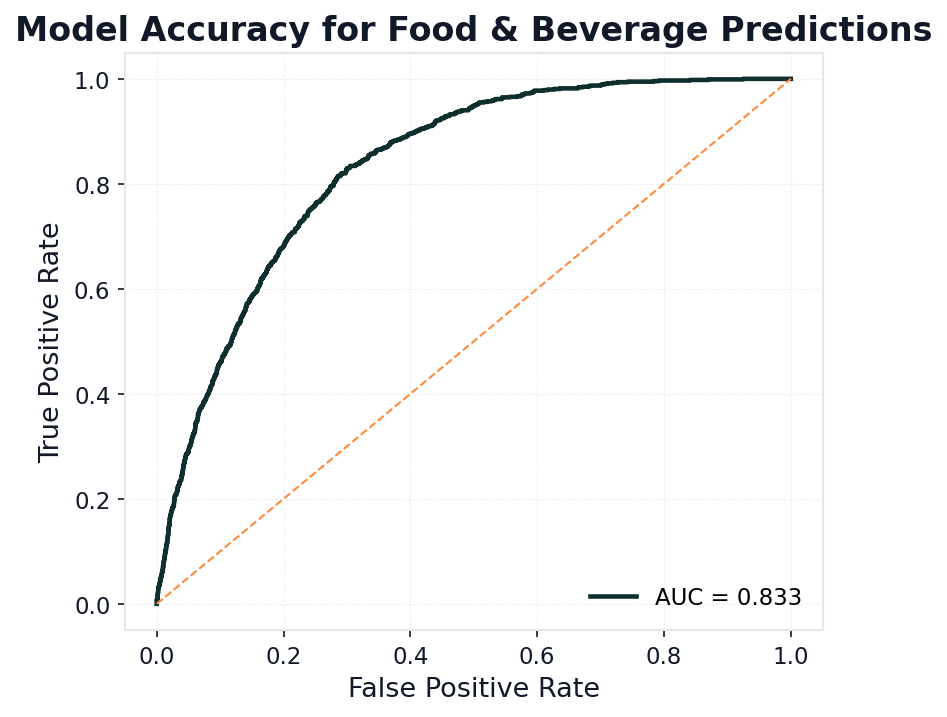

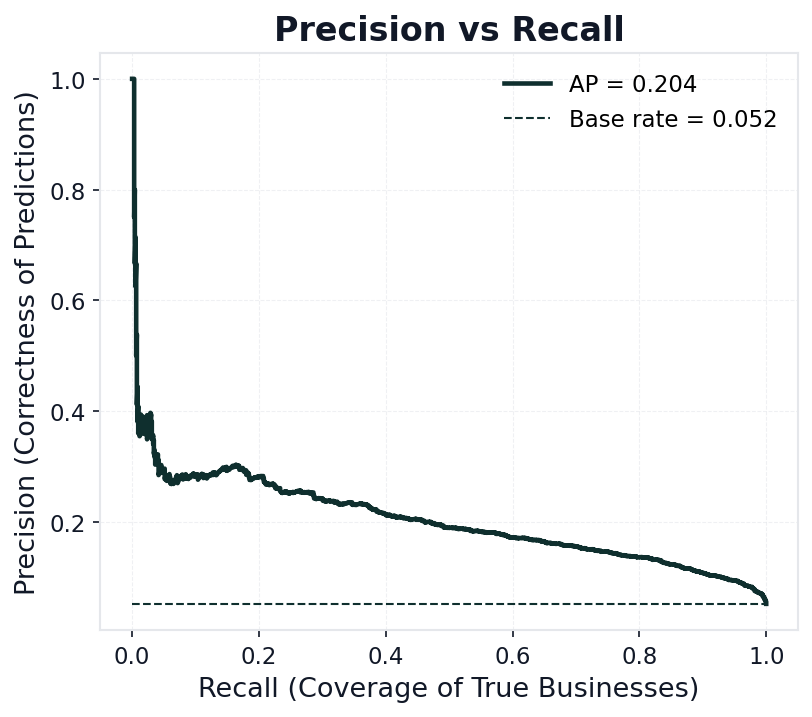

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Preconditions
assert 'best' in globals() and 'X_test' in globals() and 'y_test' in globals(), \
    "Missing variables. Re-run the last modeling cell to define best, X_test, y_test."
# If proba not present, compute now
if 'proba' not in globals():
    proba = best.predict_proba(X_test)[:, 1]

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model Accuracy for Food & Beverage Predictions")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
roc_path = OUT_FB / "q1_FB_ROC_curve.png"
plt.savefig(roc_path, dpi=150, bbox_inches="tight")
plt.show()

# --- Precision–Recall curve ---
precision, recall, _ = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)
base_rate = float(np.mean(y_test))

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.hlines(base_rate, 0, 1, linestyles="--", linewidth=1, label=f"Base rate = {base_rate:.3f}")
plt.xlabel("Recall (Coverage of True Businesses)")
plt.ylabel("Precision (Correctness of Predictions)")
plt.title("Precision vs Recall")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
pr_path = OUT_FB / "q1_FB_PR_curve.png"
plt.savefig(pr_path, dpi=150, bbox_inches="tight")
plt.show()



#### Driver bar charts (logistic model)

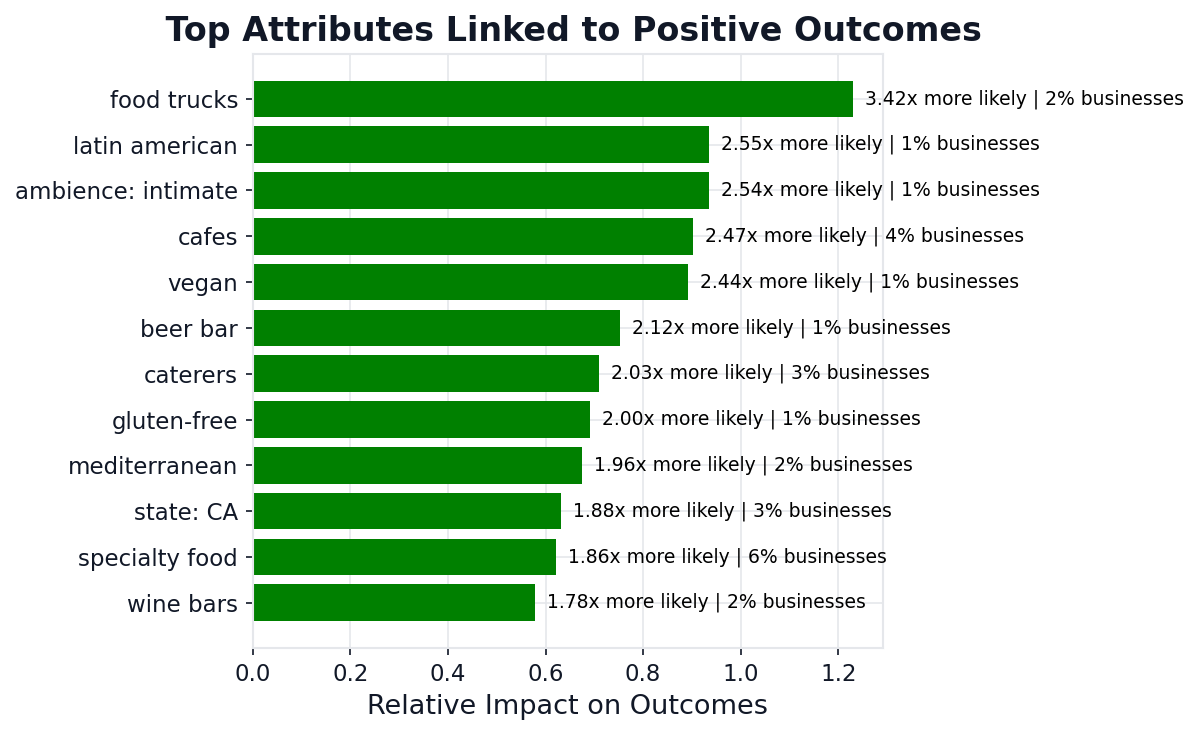

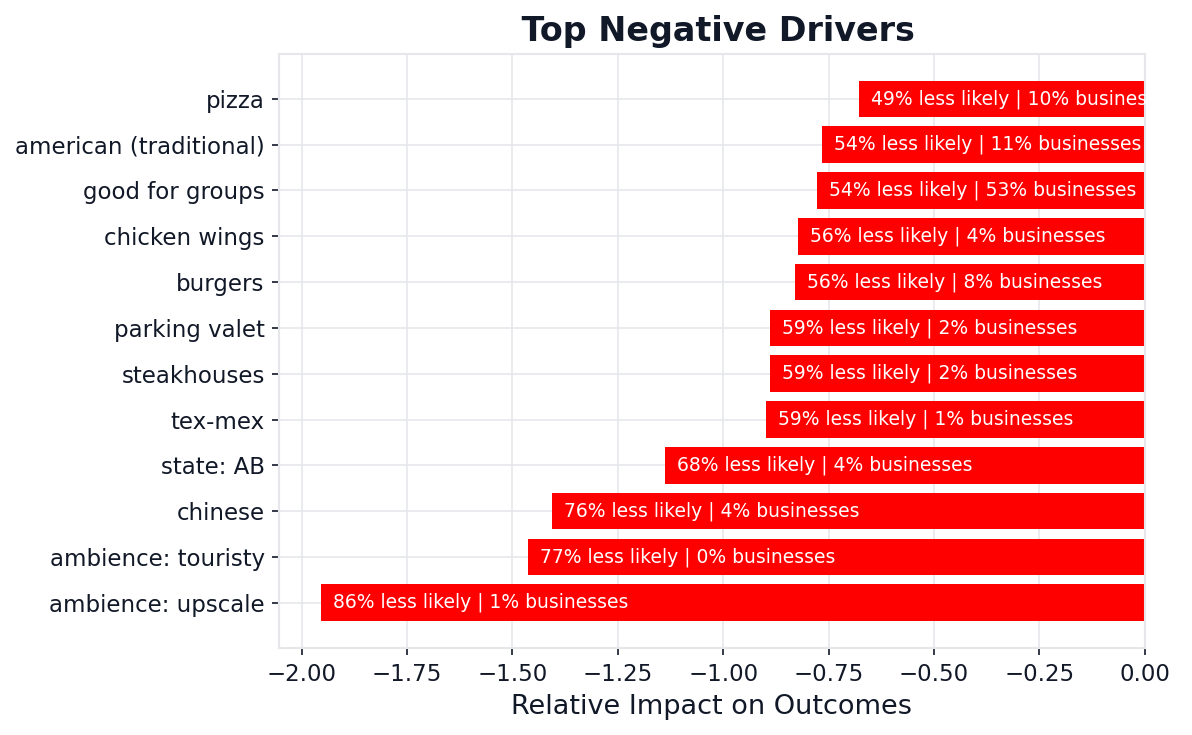

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
drivers_path = OUT_FB / "q1_FB_logit_drivers_step4_final.csv"

dfd = pd.read_csv(drivers_path)

# Optional: exclude data-quality or context features from the chart (kept in the CSV for transparency).
EXCLUDE = {"attire: Unknown"}  # add e.g. {"state: CA","state: AB"} if you want a pure “actionable” view
plot_df = dfd[~dfd["feature"].isin(EXCLUDE)].copy()

# Select top drivers
TOP_N = 12
pos_df = plot_df.sort_values("coef", ascending=False).head(TOP_N).iloc[::-1]  # reverse for horizontal plot
neg_df = plot_df.sort_values("coef", ascending=True).head(TOP_N)              # already most negative

def plot_drivers(sub, title, fname):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Drop "cuisine: " from labels for readability
    sub = sub.copy()
    sub["clean_feature"] = sub["feature"].str.replace("cuisine: ", "", regex=False)

    # Color: green for positive, red for negative
    colors = ["green" if c >= 0 else "red" for c in sub["coef"]]

    ax.barh(sub["clean_feature"], sub["coef"], color=colors)
    ax.set_xlabel("Relative Impact on Outcomes")
    ax.set_title(title)

    # Annotate with stakeholder-friendly wording
    for i, (coef, orr, sup) in enumerate(zip(sub["coef"], sub["odds_ratio"], sub["support_share"])):
        if orr >= 1:
            label = f"  {orr:.2f}x more likely | {sup:.0%} businesses"
        else:
            label = f"  {(1 - orr):.0%} less likely | {sup:.0%} businesses"
        text_color = "white" if coef < 0 else "black"
        ax.text(coef, i, label, va="center", fontsize=9, color=text_color)

    plt.tight_layout()
    out = OUT_FB / fname
    plt.savefig(out, dpi=150, bbox_inches="tight")
    plt.show()

plot_drivers(pos_df, " Top Attributes Linked to Positive Outcomes", "q1_FB_top_positive_drivers.png")
plot_drivers(neg_df, " Top Negative Drivers", "q1_FB_top_negative_drivers.png")


#### threshold selection table and summary

Base rate (positives): 0.052

Best F1 operating point:
threshold        0.780000
precision        0.233264
recall           0.361884
f1               0.283676
accuracy         0.904525
TP             338.000000
FP            1111.000000
TN           15834.000000
FN             596.000000

Precision-oriented operating point (max precision with recall ≥ 0.30):
threshold        0.780000
precision        0.233264
recall           0.361884
f1               0.283676
accuracy         0.904525
TP             338.000000
FP            1111.000000
TN           15834.000000
FN             596.000000


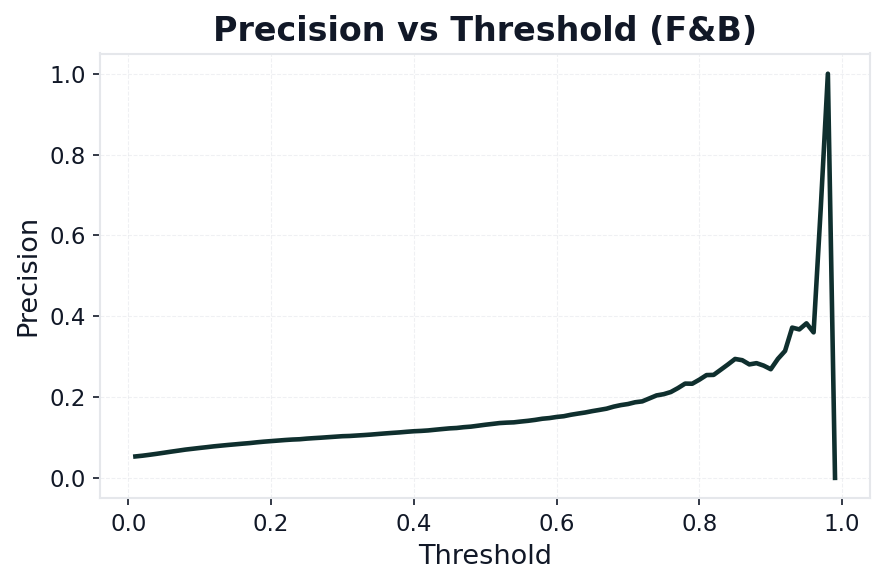

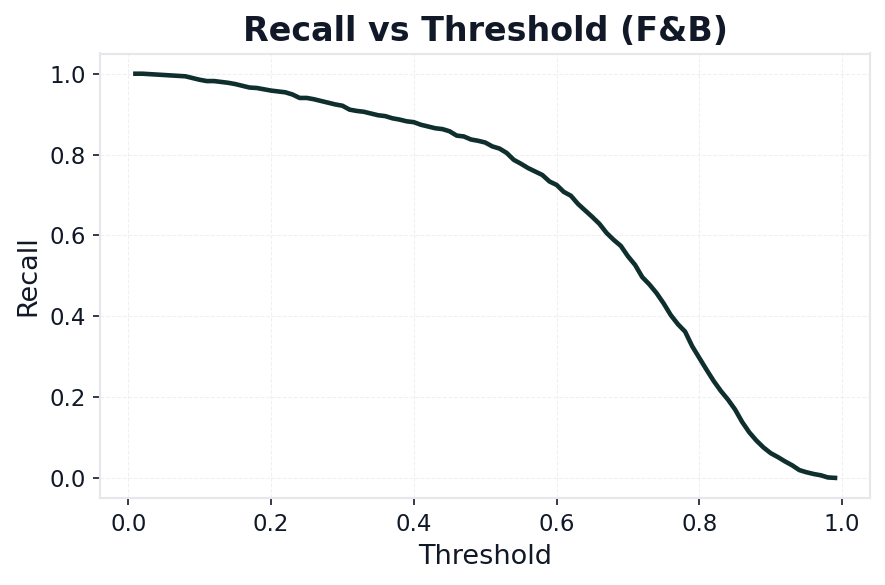

In [92]:
# Q1 / Food & Beverage — threshold selection table and summary

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

assert 'proba' in globals() and 'y_test' in globals(), "Run the modeling cell first."

OUT_FB = Path.cwd() / "outputs" / "food_&_beverage"
OUT_FB.mkdir(parents=True, exist_ok=True)

y_true = y_test.values
base_rate = float(np.mean(y_true))

# Dense grid of thresholds
ths = np.linspace(0.01, 0.99, 99)
rows = []
for t in ths:
    y_pred = (proba >= t).astype(int)
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    acc  = accuracy_score(y_true, y_pred)
    rows.append([t, tp, fp, tn, fn, prec, rec, f1, acc])

thr_df = pd.DataFrame(rows, columns=[
    "threshold","TP","FP","TN","FN","precision","recall","f1","accuracy"
])

# Operating-point suggestions
# 1) Highest F1
best_f1_row = thr_df.iloc[thr_df["f1"].idxmax()]
# 2) Precision-oriented: max precision with recall >= 0.30 (tune if you prefer another floor)
cand = thr_df[thr_df["recall"] >= 0.30]
best_prec_row = cand.iloc[cand["precision"].idxmax()] if len(cand) else thr_df.iloc[thr_df["precision"].idxmax()]

print(f"Base rate (positives): {base_rate:.3f}")
print("\nBest F1 operating point:")
print(best_f1_row[["threshold","precision","recall","f1","accuracy","TP","FP","TN","FN"]].to_string())

print("\nPrecision-oriented operating point (max precision with recall ≥ 0.30):")
print(best_prec_row[["threshold","precision","recall","f1","accuracy","TP","FP","TN","FN"]].to_string())

# Save table
out_csv = OUT_FB / "q1_FB_threshold_table.csv"
thr_df.to_csv(out_csv, index=False)

# Optional: simple metric vs threshold plots (two separate figures)
plt.figure(figsize=(6,4))
plt.plot(thr_df["threshold"], thr_df["precision"])
plt.xlabel("Threshold"); plt.ylabel("Precision"); plt.title("Precision vs Threshold (F&B)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.savefig(OUT_FB / "q1_FB_precision_vs_threshold.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(thr_df["threshold"], thr_df["recall"])
plt.xlabel("Threshold"); plt.ylabel("Recall"); plt.title("Recall vs Threshold (F&B)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.savefig(OUT_FB / "q1_FB_recall_vs_threshold.png", dpi=150, bbox_inches="tight")
plt.show()
